In [1]:
%load_ext autoreload
%autoreload 2

# <span style="color:#c6aa3d">0. Importing libraries and defining paths</span><a class="anchor" id="0-bullet"></a>

### 0.1 Importing libraries

In [2]:
# Importing python libraries
import sys
import os
import joblib
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import random
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from datetime import date, datetime
from fbprophet.make_holidays import make_holidays_df
from multiprocessing import Pool,cpu_count
import statsmodels.api as sm
from joblib import Parallel, delayed

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Setting the default max row and column display
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [4]:
# Path to src folder
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)

# Import own scripts
import src.config as config
import src.custom_funcs as custom_funcs
from src.util import *
from src.run_pool import generate_2_steps_models
import src.core.feature_creation as fc
import src.core.globals as glob

### 0.2 Defining paths

In [5]:
# a string to create different output folder and not overwrite results
label_out = 'simple_model_total_test'

In [6]:
# Input/Output Folder
raw_data_path = "./../data/raw/"
interim_data_path = "./../data/interim/"

model_output_path = "./model/"+label_out+"/"
notebook_output_path = "./output/1. Baseline calculation/"
baseline_interim_out_path = "./interim_output/1. Baseline calculation/"

if not os.path.exists(model_output_path):
    print(model_output_path)
    os.mkdir(model_output_path)

# <span style="color:#c6aa3d">1. Processing sales data</span><a class="anchor" id="1-bullet"></a>

### 1.1 Reading and combining Sales Data

In [7]:
df_sales_2020 = pd.read_csv(raw_data_path + "20220303_Sales_2020.csv", dtype=config.sales_data_col_types)

In [8]:
df_sales_2021 = pd.read_csv(raw_data_path + "20220303_Sales_2021.csv", dtype=config.sales_data_col_types)

In [9]:
df_sales_2022 = pd.read_csv(raw_data_path + "20220303_Sales_2022.csv", dtype=config.sales_data_col_types)

In [10]:
# Printing shapes of all sales datasets
print(f"2020 data shape: {df_sales_2020.shape}, 2021 data shape: {df_sales_2021.shape}, 2022 data shape: {df_sales_2022.shape}")

2020 data shape: (1615509, 49), 2021 data shape: (1573716, 49), 2022 data shape: (318520, 49)


In [11]:
df_sales_2020.head()

,DATES,STORE_NUMBER,STORE_NAME,POS_NUMBER,TICKET_NUMBER,CHANNEL,DEPARTMANT,SUBDEPARTMENT,CLASS,SUBCLASS,BRAND_GROUP,BRAND_NAME,SUPPLIER_GROUP,SUPPLIER_NAME,SKU_NUMBER,PRODUCT_NAME,PRODUCT_IBC,PRODUCT_SBC,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,PRODUCT_STATUS,PRODUCT_CATALOG_NUMBER,PRODUCT_SEASONAL_CODE,PRODUCT_SIZE_AND_COLOR,PRODUCT_COLOR,PRODUCT_MANUFACTURER_NUMBER,PRODUCT_SIZES,PRODUCT_SEASON,PRODUCT_SEASON_DESC,CREDIT_CONSIGN,MEMBER_ID,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT
0,20200101,10102,Chidlom,NaN,NaN,Offline,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,CLAUDIA KLEID,CLAUDIA KLEID,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0.00,0.00,,NaN,NON,NaN,Consignment,NaN,2,0.0,0.0,7084.10,7580.0,0.0,0.0,3674.00,3433.64,0.0,0.0,3650.46,3906.00,1137.0,379.0,0.0,3230.3551,420.1049
1,20200102,10102,Chidlom,NaN,NaN,Offline,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,CLAUDIA KLEID,CLAUDIA KLEID,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0.00,0.00,,NaN,NON,NaN,Consignment,NaN,1,0.0,0.0,3448.60,3690.0,0.0,0.0,1161.83,1085.82,0.0,0.0,2362.78,2528.17,553.5,184.5,0.0,1572.5607,790.2193
2,20200102,10102,Chidlom,NaN,NaN,Offline,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,CLAUDIA KLEID,CLAUDIA KLEID,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0.00,0.00,,NaN,NON,NaN,Consignment,NaN,5,0.0,0.0,17803.75,19050.0,0.0,0.0,5334.00,4985.05,0.0,0.0,12818.70,13716.00,2667.0,952.5,0.0,8309.0046,4509.6954
3,20200103,10102,Chidlom,NaN,NaN,Offline,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,CLAUDIA KLEID,CLAUDIA KLEID,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0.00,0.00,,NaN,NON,NaN,Consignment,NaN,7,0.0,0.0,17504.69,18730.0,0.0,0.0,6683.37,6246.15,0.0,0.0,11258.54,12046.63,2799.0,936.5,0.0,7992.6307,3265.9093
4,20200103,10102,Chidlom,NaN,NaN,Offline,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,CLAUDIA KLEID,CLAUDIA KLEID,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0.00,0.00,,NaN,NON,NaN,Consignment,NaN,13,0.0,0.0,44644.85,47770.0,0.0,0.0,14331.00,13393.46,0.0,0.0,31251.39,33439.00,7165.5,2388.5,0.0,20358.0561,10893.3339


In [12]:
df_sales_2021.head()

,DATES,STORE_NUMBER,STORE_NAME,POS_NUMBER,TICKET_NUMBER,CHANNEL,DEPARTMANT,SUBDEPARTMENT,CLASS,SUBCLASS,BRAND_GROUP,BRAND_NAME,SUPPLIER_GROUP,SUPPLIER_NAME,SKU_NUMBER,PRODUCT_NAME,PRODUCT_IBC,PRODUCT_SBC,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,PRODUCT_STATUS,PRODUCT_CATALOG_NUMBER,PRODUCT_SEASONAL_CODE,PRODUCT_SIZE_AND_COLOR,PRODUCT_COLOR,PRODUCT_MANUFACTURER_NUMBER,PRODUCT_SIZES,PRODUCT_SEASON,PRODUCT_SEASON_DESC,CREDIT_CONSIGN,MEMBER_ID,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT
0,20210202,10102,Chidlom,331,006470,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,DEFRY 01,DEFRY 01 WOMEN,Others,ELITA & CO. PTE LTD,6534875,เสื้อ RE L,71008769,0,1890.0,499.0,Active,999,NON,L-340.,340.,2101ECSW004,L,NON,NaN,Credit,1011010090128523,1,0.0,0.0,1397.19,1495.0,0.0,0.0,186.88,174.65,0.0,0.0,1222.54,1308.12,0.0,0.0,0.0,644.916,577.624
1,20210203,10102,Chidlom,331,006534,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,DEFRY 01,DEFRY 01 WOMEN,Others,ELITA & CO. PTE LTD,6534875,เสื้อ RE L,71008769,0,1890.0,499.0,Active,999,NON,L-340.,340.,2101ECSW004,L,NON,NaN,Credit,2011675475,1,0.0,0.0,1397.20,1495.0,0.0,0.0,112.42,105.07,0.0,0.0,1292.13,1382.58,0.0,0.0,0.0,644.916,647.214
2,20210206,10102,Chidlom,334,464256,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,DEFRY 01,DEFRY 01 WOMEN,Others,ELITA & CO. PTE LTD,6534875,เสื้อ RE L,71008769,0,1890.0,499.0,Active,999,NON,L-340.,340.,2101ECSW004,L,NON,NaN,Credit,8017442837,1,0.0,0.0,1397.20,1495.0,0.0,0.0,33.33,31.15,0.0,0.0,1366.05,1461.67,0.0,0.0,0.0,644.916,721.134
3,20210121,10102,Chidlom,331,005596,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,DEFRY 01,DEFRY 01 WOMEN,Others,ELITA & CO. PTE LTD,6534875,เสื้อ RE L,71008769,0,1890.0,499.0,Active,999,NON,L-340.,340.,2101ECSW004,L,NON,NaN,Credit,2402067377,1,0.0,0.0,1397.20,1495.0,0.0,0.0,0.00,0.00,0.0,0.0,1397.20,1495.00,0.0,0.0,0.0,644.916,752.284
4,20210121,10102,Chidlom,331,005568,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,DEFRY 01,DEFRY 01 WOMEN,Others,ELITA & CO. PTE LTD,6534875,เสื้อ RE L,71008769,0,1890.0,499.0,Active,999,NON,L-340.,340.,2101ECSW004,L,NON,NaN,Credit,1011010088145679,1,0.0,0.0,1397.20,1495.0,0.0,0.0,0.00,0.00,0.0,0.0,1397.20,1495.00,0.0,0.0,0.0,644.916,752.284


In [13]:
df_sales_2022.head()

,DATES,STORE_NUMBER,STORE_NAME,POS_NUMBER,TICKET_NUMBER,CHANNEL,DEPARTMANT,SUBDEPARTMENT,CLASS,SUBCLASS,BRAND_GROUP,BRAND_NAME,SUPPLIER_GROUP,SUPPLIER_NAME,SKU_NUMBER,PRODUCT_NAME,PRODUCT_IBC,PRODUCT_SBC,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,PRODUCT_STATUS,PRODUCT_CATALOG_NUMBER,PRODUCT_SEASONAL_CODE,PRODUCT_SIZE_AND_COLOR,PRODUCT_COLOR,PRODUCT_MANUFACTURER_NUMBER,PRODUCT_SIZES,PRODUCT_SEASON,PRODUCT_SEASON_DESC,CREDIT_CONSIGN,MEMBER_ID,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT
0,20220102,10166,Khonkaen,201,004918,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,103 - DRESS,002 - MIDI DRESS,EXPRESSIONS,EXPRESSIONS,Others,ELITA & CO. PTE LTD,6534964,ชุดกระโปรงแขนสั้น A1 BL XS,71009667,0,2595.0,1295.0,Active,999,NON,XS-65.,65.0,2101ECDE001,XS,NON,NaN,Credit,8013383080,1,1214.95,1300.0,1210.28,1295.0,0.0,0.0,0.00,0.00,0.0,0.0,1210.28,1295.00,0.0,0.0,0.0,702.55,507.73
1,20220104,10158,Mega Bangna,105,045852,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,103 - DRESS,002 - MIDI DRESS,EXPRESSIONS,EXPRESSIONS,Others,ELITA & CO. PTE LTD,6534964,ชุดกระโปรงแขนสั้น A1 BL XS,71009667,0,2595.0,1295.0,Active,999,NON,XS-65.,65.0,2101ECDE001,XS,NON,NaN,Credit,2110738217,1,1214.95,1300.0,1210.28,1295.0,0.0,0.0,0.00,0.00,0.0,0.0,1210.28,1295.00,0.0,0.0,0.0,702.55,507.73
2,20220116,10149,WestGate,204,036643,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,103 - DRESS,002 - MIDI DRESS,EXPRESSIONS,EXPRESSIONS,Others,ELITA & CO. PTE LTD,6534964,ชุดกระโปรงแขนสั้น A1 BL XS,71009667,0,2595.0,1295.0,Active,999,NON,XS-65.,65.0,2101ECDE001,XS,NON,NaN,Credit,8014764635,1,1214.95,1300.0,1210.28,1295.0,0.0,0.0,259.00,242.06,0.0,0.0,968.22,1036.00,0.0,0.0,0.0,702.55,265.67
3,20220123,10105,Ramindra,201,005378,Offline,003 - WOMEN,301 - YOUNG MISS APPARELS,103 - DRESS,002 - MIDI DRESS,EXPRESSIONS,EXPRESSIONS,Others,ELITA & CO. PTE LTD,6534964,ชุดกระโปรงแขนสั้น A1 BL XS,71009667,0,2595.0,1295.0,Active,999,NON,XS-65.,65.0,2101ECDE001,XS,NON,NaN,Credit,8030589717,1,1214.95,1300.0,1210.28,1295.0,0.0,0.0,0.00,0.00,0.0,0.0,1210.28,1295.00,0.0,0.0,0.0,702.55,507.73
4,20220127,15017,Rama III Online,260,064,Online,003 - WOMEN,301 - YOUNG MISS APPARELS,103 - DRESS,002 - MIDI DRESS,EXPRESSIONS,EXPRESSIONS,Others,ELITA & CO. PTE LTD,6534964,ชุดกระโปรงแขนสั้น A1 BL XS,71009667,0,2595.0,1295.0,Active,999,NON,XS-65.,65.0,2101ECDE001,XS,NON,NaN,Credit,NaN,1,1214.95,1300.0,1210.28,1295.0,0.0,0.0,90.65,84.72,0.0,0.0,1125.56,1204.35,0.0,0.0,0.0,702.55,423.01


In [14]:
# Combining sales for all focus years
df_sales = pd.concat([df_sales_2020, df_sales_2021, df_sales_2022])

In [15]:
# Check shape of combined data and that its rows equal the row sum of base datasets
print(f"Shape of combined data: {df_sales.shape}")
combined_sales_rows_equality = (df_sales.shape[0]==(df_sales_2020.shape[0]+df_sales_2021.shape[0]+df_sales_2022.shape[0]))

assert combined_sales_rows_equality==True, "Number of rows of combined sales doesn't equal row sum of base sales datasets"

Shape of combined data: (3507745, 49)


### 1.2 Preliminary processing of sales data

In [16]:
df_sales['Date'] = pd.to_datetime(df_sales['DATES'])

# Filtering data for only relevant period
df_sales = df_sales[df_sales['Date'] <= config.sales_data_cutoff_date]
df_sales = df_sales.reset_index(drop=True)

print(df_sales.shape)

(3370557, 50)


In [17]:
# Removes leading zeros from POS and Ticket, if any
df_sales['POS_NUMBER'] = df_sales['POS_NUMBER'].astype('str').apply(custom_funcs.remove_leading_zeros)
df_sales['TICKET_NUMBER'] = df_sales['TICKET_NUMBER'].astype('str').apply(custom_funcs.remove_leading_zeros)

# Week start and end dates
df_sales['Week Start'] = df_sales['Date'].dt.to_period('W-THU').apply(lambda r: r.start_time)
df_sales['Week End'] = df_sales['Week Start'] + pd.DateOffset(6)

# Defining a field 'Disc' which is same as EPOS Discount
df_sales['Disc'] = df_sales['TOTAL_DISCOUNT_AMT_INC_VAT']



In [18]:
# Reordering sales data columns
sales_data_field_ordering = ['Date','Week Start','Week End'] + list(config.sales_data_col_types.keys()) + ['Disc']

df_sales = df_sales[sales_data_field_ordering]
df_sales = df_sales.drop(columns=['DATES'])

### 1.3 EDA on sales data

In [19]:
df_sales.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370557 entries, 0 to 3370556
Data columns (total 52 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Date                         3370557 non-null  datetime64[ns]
 1   Week Start                   3370557 non-null  datetime64[ns]
 2   Week End                     3370557 non-null  datetime64[ns]
 3   POS_NUMBER                   1755048 non-null  object        
 4   TICKET_NUMBER                1753126 non-null  object        
 5   CHANNEL                      3370557 non-null  object        
 6   SUPPLIER_GROUP               3370557 non-null  object        
 7   SUPPLIER_NAME                3370557 non-null  object        
 8   SKU_NUMBER                   3370557 non-null  object        
 9   PRODUCT_NAME                 3370557 non-null  object        
 10  PRODUCT_IBC                  3370557 non-null  object        
 11  PRODUCT_SBC

In [20]:
df_sales.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT,Disc
count,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557,3370557
mean,1314,662,1,247,264,1529,1636,16,17,306,286,1,1,1226,1312,101,14,0,900,327,306
std,1507,960,2,687,735,2648,2833,106,113,710,663,34,37,2255,2413,336,78,0,1614,765,710
min,0,0,-4,-16977,-18165,-103729,-110990,-1772,-1896,-12151,-11356,-2738,-2930,-103729,-110990,-5800,-2988,0,-77797,-37008,-12151
25%,0,0,1,0,0,542,580,0,0,0,0,0,0,453,485,0,0,0,348,73,0
50%,1290,399,1,0,0,930,995,0,0,20,18,0,0,786,842,0,0,0,557,208,20
75%,1890,890,1,0,0,1678,1795,0,0,398,372,0,0,1304,1395,0,2,0,929,442,398
max,139000,29900,447,108038,115600,726449,777301,9692,10370,120619,112728,8364,8950,726449,777301,68893,15072,0,537064,189385,120619


In [21]:
# Checking the max value of Net Sales
df_sales[df_sales['NET_SALES_AMT_EXC_VAT']==df_sales['NET_SALES_AMT_EXC_VAT'].max()]

,Date,Week Start,Week End,POS_NUMBER,TICKET_NUMBER,CHANNEL,SUPPLIER_GROUP,SUPPLIER_NAME,SKU_NUMBER,PRODUCT_NAME,PRODUCT_IBC,PRODUCT_SBC,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,PRODUCT_STATUS,PRODUCT_CATALOG_NUMBER,PRODUCT_SEASONAL_CODE,PRODUCT_SIZE_AND_COLOR,PRODUCT_COLOR,PRODUCT_MANUFACTURER_NUMBER,PRODUCT_SIZES,PRODUCT_SEASON,PRODUCT_SEASON_DESC,CREDIT_CONSIGN,BRAND_GROUP,BRAND_NAME,MEMBER_ID,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT,STORE_NUMBER,STORE_NAME,DEPARTMANT,SUBDEPARTMENT,CLASS,SUBCLASS,Disc
729871,2020-09-26,2020-09-25,2020-09-25,NaN,NaN,New channels,Others,"Y.M.F.INTERNATIONAL THAI CO.,LTD.",2383351,เสื้อชุดPRO YACCOMARICARD,88636467,0,0.0,0.0,Active,999,SEA,0,0,NaN,NaN,SEA,NaN,Consignment,YACCOMARICARD,YACCOMARICARD PRO,NaN,127,0.0,0.0,726449.49,777301.0,0.0,0.0,0.0,0.0,0.0,0.0,726449.49,777301.0,0.0,7773.01,0.0,537064.1399,189385.3501,10116,Bangna,003 - WOMEN,302 - MISSY APPARELS,101 - TOP,001 - BLOUSE,0.0


### 1.4 Defining new SKU number (*sku_id_upd*) which disregards size

In [22]:
# Trimming string fields and converting blanks to NaNs
for var in config.sku_defining_cols:
    if var!='Product_name_wo_size':
        if not np.issubdtype(df_sales[var], np.number):
            df_sales[var] = df_sales[var].astype('str').apply(custom_funcs.trim_and_convert_blanks_to_nan)

In [23]:
# Removing leading zeros from PRODUCT_MANUFACTURER_NUMBER field
df_sales['PRODUCT_MANUFACTURER_NUMBER'] = df_sales['PRODUCT_MANUFACTURER_NUMBER'].astype('str').apply(custom_funcs.remove_leading_zeros)

In [24]:
# Converting values like 215.0 to 215
for var in ['PRODUCT_COLOR', 'PRODUCT_SIZE_AND_COLOR']:
    df_sales[var] = df_sales[var].astype('str').apply(custom_funcs.delimit_on_char, delimiter=".", part=0)

In [25]:
# Solving for cases where PRODUCT_SIZES is missing or if Prod Name has 2XL whereas Size has XXL, etc.
# Taking top sizes that cover ~85% transactions
all_sku_sizes = df_sales['PRODUCT_SIZES'].value_counts(dropna=True, normalize=True, ascending=False).reset_index(). \
                                            rename(columns={'index':'Size', 'PRODUCT_SIZES':'perc'})
all_sku_sizes['cum_size_perc'] = all_sku_sizes['perc'].cumsum()
top_sku_sizes = all_sku_sizes[all_sku_sizes['cum_size_perc']<=0.85]['Size'].to_list()
print(top_sku_sizes)

['M', 'S', 'L', 'XL', 'XS', 'F', '10', '8', '12', '14', '36', '38', '6', '16', '34', '40', '18']


In [26]:
# Adding custom sizes from config
top_sku_sizes = top_sku_sizes + config.custom_size_list

# Removing duplicates in case the size is in top 85% but also in custom list
top_sku_sizes = list(dict.fromkeys(top_sku_sizes))

In [27]:
# Remove sizes at the end of product name and create field 'Product_name_wo_size'

# Step1: If PRODUCT_SIZES is null, then check if last word in PRODUCT_NAME matches any value in top_sizes_list and remove if yes
# Step2: Else If PRODUCT_SIZES is null then get PRODUCT_NAME as-is
# Step3: Else If PRODUCT_SIZES is filled, check if PRODUCT_NAME contains PRODUCT_SIZES value at the end. Remove if yes
# Step4: Else if PRODUCT_NAME contains top_sizes_list value at the end then remove the size
# Step5: Else if none of the above, get PRODUCT_NAME as-is
df_sales['Product_name_wo_size'] = df_sales.apply(lambda x: (' ').join(x['PRODUCT_NAME'].split()[:-1]) if (pd.isnull(x['PRODUCT_SIZES']) and x['PRODUCT_NAME'].split()[-1] in top_sku_sizes) else \
                                                         x['PRODUCT_NAME'] if pd.isnull(x['PRODUCT_SIZES']) else \
                                                        (' ').join(x['PRODUCT_NAME'].split()[:-1]) if x['PRODUCT_NAME'].split()[-1]==x['PRODUCT_SIZES'] else \
                                                        (' ').join(x['PRODUCT_NAME'].split()[:-1]) if x['PRODUCT_NAME'].split()[-1] in top_sku_sizes
                                                        else x['PRODUCT_NAME'], axis=1)

In [28]:
# Check values
df_sales[['PRODUCT_NAME', 'PRODUCT_SIZES', 'Product_name_wo_size']].tail()

,PRODUCT_NAME,PRODUCT_SIZES,Product_name_wo_size
3370552,ชุดกระโปรงแขนCAP RE XL,XL,ชุดกระโปรงแขนCAP RE
3370553,ชุดกระโปรงแขนกุด RE L,L,ชุดกระโปรงแขนกุด RE
3370554,ชุดกระโปรงแขนกุด RE L,L,ชุดกระโปรงแขนกุด RE
3370555,ชุดกระโปรงแขนกุด RE L,L,ชุดกระโปรงแขนกุด RE
3370556,ชุดกระโปรงแขนกุด RE L,L,ชุดกระโปรงแขนกุด RE


In [29]:
# Defining new SKU id as a combination of several fields given by 'sku_defining_cols'
df_sku_new = df_sales.groupby(config.sku_defining_cols, dropna=False).size().to_frame('size').reset_index()

In [30]:
df_sku_new.shape

(64861, 16)

In [31]:
df_sku_new['sku_id_upd'] = np.arange(df_sku_new.shape[0])+1
df_sku_new['sku_id_upd'] = df_sku_new['sku_id_upd'].astype('str')

In [32]:
df_sku_new = df_sku_new.drop(columns='size')

In [33]:
df_sales = df_sales.merge(df_sku_new, on=config.sku_defining_cols, how='inner')

In [34]:
df_sales.shape

(3370557, 54)

In [35]:
df_sales.head()

,Date,Week Start,Week End,POS_NUMBER,TICKET_NUMBER,CHANNEL,SUPPLIER_GROUP,SUPPLIER_NAME,SKU_NUMBER,PRODUCT_NAME,PRODUCT_IBC,PRODUCT_SBC,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,PRODUCT_STATUS,PRODUCT_CATALOG_NUMBER,PRODUCT_SEASONAL_CODE,PRODUCT_SIZE_AND_COLOR,PRODUCT_COLOR,PRODUCT_MANUFACTURER_NUMBER,PRODUCT_SIZES,PRODUCT_SEASON,PRODUCT_SEASON_DESC,CREDIT_CONSIGN,BRAND_GROUP,BRAND_NAME,MEMBER_ID,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT,STORE_NUMBER,STORE_NAME,DEPARTMANT,SUBDEPARTMENT,CLASS,SUBCLASS,Disc,Product_name_wo_size,sku_id_upd
0,2020-01-01,2019-12-27,2019-12-27,NaN,NaN,Offline,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,CLAUDIA KLEID,CLAUDIA KLEID,NaN,2,0.0,0.0,7084.10,7580.0,0.0,0.0,3674.00,3433.64,0.0,0.0,3650.46,3906.00,1137.0,379.0,0.0,3230.3551,420.1049,10102,Chidlom,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,3674.00,เสื้อชุดสตรี CLAUDIA KLEID,63616
1,2020-01-02,2019-12-27,2019-12-27,NaN,NaN,Offline,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,CLAUDIA KLEID,CLAUDIA KLEID,NaN,1,0.0,0.0,3448.60,3690.0,0.0,0.0,1161.83,1085.82,0.0,0.0,2362.78,2528.17,553.5,184.5,0.0,1572.5607,790.2193,10102,Chidlom,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,1161.83,เสื้อชุดสตรี CLAUDIA KLEID,63616
2,2020-01-02,2019-12-27,2019-12-27,NaN,NaN,Offline,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,CLAUDIA KLEID,CLAUDIA KLEID,NaN,5,0.0,0.0,17803.75,19050.0,0.0,0.0,5334.00,4985.05,0.0,0.0,12818.70,13716.00,2667.0,952.5,0.0,8309.0046,4509.6954,10102,Chidlom,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,5334.00,เสื้อชุดสตรี CLAUDIA KLEID,63616
3,2020-01-03,2020-01-03,2020-01-03,NaN,NaN,Offline,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,CLAUDIA KLEID,CLAUDIA KLEID,NaN,7,0.0,0.0,17504.69,18730.0,0.0,0.0,6683.37,6246.15,0.0,0.0,11258.54,12046.63,2799.0,936.5,0.0,7992.6307,3265.9093,10102,Chidlom,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,6683.37,เสื้อชุดสตรี CLAUDIA KLEID,63616
4,2020-01-03,2020-01-03,2020-01-03,NaN,NaN,Offline,Others,"P.N.L.CO.,LTD.",1602292,เสื้อชุดสตรี CLAUDIA KLEID,6234737,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,CLAUDIA KLEID,CLAUDIA KLEID,NaN,13,0.0,0.0,44644.85,47770.0,0.0,0.0,14331.00,13393.46,0.0,0.0,31251.39,33439.00,7165.5,2388.5,0.0,20358.0561,10893.3339,10102,Chidlom,003 - WOMEN,302 - MISSY APPARELS,104 - OUTERWEAR,002 - COAT,14331.00,เสื้อชุดสตรี CLAUDIA KLEID,63616


# <span style="color:#c6aa3d">2. Processing store data</span><a class="anchor" id="2-bullet"></a>

### 2.1 Reading store mapping data

In [36]:
# Reading store mapping data
store = pd.read_csv(raw_data_path + "store_v2.csv", dtype = {'STORE_NUMBER': object})
store.columns = [x.lower() for x in store.columns]
store = store.drop(columns=['store_name'])

In [37]:
store.head()

,store_number,store_brand,store_group,segment,store_type,store_location_name,banner
0,10139,CDS,CDS,Brand Shop,Brand Shop,M&S Chiangmai 2,Others
1,10183,CDS,CDS,Core + L,Department store,Rangsit,Others
2,20194,RBS,RBS,Brand Shop,Brand Shop,Saraburi,Others
3,14149,CDS,CDS,Core + L,Department store,WestGate,Others
4,20152,RBS,RBS,Brand Shop,Brand Shop,PAYLESS SHOES PINKLAO,Others


In [38]:
# Check uniqueness and blanks in store numbers
unique_frac_store_num = store.store_number.nunique()/store.shape[0]
missing_frac_store_num = store.store_number.isna().sum()/store.shape[0]

assert unique_frac_store_num==1, "Duplicate values in store_number field"
assert missing_frac_store_num==0, "Missing values in store_number field"

In [39]:
store= store[['store_number', 'banner']]
store= store.rename(columns={'store_number': 'STORE_NUMBER'})

### 2.2 Merging store data into sales data

In [40]:
sales_filter = df_sales.copy()

sales_filter = pd.merge(sales_filter, store, on=['STORE_NUMBER'], how='left')

In [41]:
# Check
sales_filter['banner'].value_counts(dropna=False)

CDS       1660474
RBS       1138364
Others     571719
Name: banner, dtype: int64

# <span style="color:#c6aa3d">3. Sales data filtering</span><a class="anchor" id="3-bullet"></a>

### 3.1 Creating date fields

In [42]:
sales_filter['year'] =  sales_filter['Date'].dt.year
sales_filter['month'] =  sales_filter['Date'].dt.month

In [43]:
sales_filter = sales_filter.rename(columns={'Week Start': 'week_start_date', 'Week End': 'week_end_date'})

In [44]:
# Check values
sales_filter[['Date','week_start_date', 'week_end_date']].tail(5)

,Date,week_start_date,week_end_date
3370552,2022-01-23,2022-01-21,2022-01-21
3370553,2022-01-24,2022-01-21,2022-01-21
3370554,2022-01-22,2022-01-21,2022-01-21
3370555,2022-01-31,2022-01-28,2022-01-28
3370556,2022-01-30,2022-01-28,2022-01-28


### 3.2 Creating duplicate SKU flag

In [45]:
sales_filter['disc_x100']=(sales_filter['Disc']*100).astype(int)

In [46]:
# check for duplicated SKUs
ID = ['Date', 'STORE_NUMBER', 'POS_NUMBER', 'TICKET_NUMBER', 'SKU_NUMBER', 'disc_x100']
sales_filter['duplicates'] = sales_filter.duplicated(subset=ID)
SKU_duplicated_2021_2022 = sales_filter.loc[(sales_filter['year']>=2021) & (sales_filter['duplicates']==True), 'SKU_NUMBER']
SKU_duplicated_2021_2022 = SKU_duplicated_2021_2022.drop_duplicates()

print(SKU_duplicated_2021_2022.shape)

(492,)


In [47]:
# Creating duplicate SKUs flag
sales_filter['dup_SKU_21_22_flag'] = 0
sales_filter.loc[sales_filter['SKU_NUMBER'].isin(SKU_duplicated_2021_2022), 'dup_SKU_21_22_flag'] = 1

In [48]:
sales_filter['dup_SKU_21_22_flag'].value_counts(dropna=False)

0    2486274
1     884283
Name: dup_SKU_21_22_flag, dtype: int64

In [49]:
sales_filter['store_banner_flag'] = 1
sales_filter.loc[sales_filter['banner'].isin(['CDS', 'RBS']), 'store_banner_flag'] = 0

In [50]:
sales_filter.groupby('dup_SKU_21_22_flag')['store_banner_flag'].value_counts(dropna=False)

dup_SKU_21_22_flag  store_banner_flag
0                   0                    1942673
                    1                     543601
1                   0                     856165
                    1                      28118
Name: store_banner_flag, dtype: int64

### 3.4 Creating zero price SKU flag

In [51]:
sales_filter['zero_reg_price_flag'] = 0
sales_filter.loc[sales_filter['PRODUCT_REGULAR_PRICE']==0, 'zero_reg_price_flag'] = 1

In [52]:
sales_filter.groupby(['dup_SKU_21_22_flag', 'store_banner_flag'])['zero_reg_price_flag'].value_counts(dropna=False)

dup_SKU_21_22_flag  store_banner_flag  zero_reg_price_flag
0                   0                  0                      1817955
                                       1                       124718
                    1                  0                       535187
                                       1                         8414
1                   0                  1                       849645
                                       0                         6520
                    1                  1                        26684
                                       0                         1434
Name: zero_reg_price_flag, dtype: int64

### 3.5 Filtering Sales data

In [53]:
model_df = sales_filter.copy()

In [54]:
#Filter for all flags
model_df = model_df[model_df['store_banner_flag']==0]
model_df = model_df[model_df['zero_reg_price_flag']==0]
model_df = model_df[model_df['dup_SKU_21_22_flag']==0]

In [55]:
model_df.shape

(1817955, 62)

# <span style="color:#c6aa3d">4. Sales data rollup to weekly level</span><a class="anchor" id="4-bullet"></a>

### 4.1 Rolling sales data at Banner/SKU/week level

In [56]:
group = config.grouping_vars_weekly

In [57]:
model_df['Disc'] = model_df['Disc'].fillna(0)
model_df['PROMOTION_MARKDOWN_INC_VAT'] = model_df['PROMOTION_MARKDOWN_INC_VAT'].fillna(0)
model_df['EPOS_MARKDOWN_INC_VAT'] = model_df['EPOS_MARKDOWN_INC_VAT'].fillna(0)

In [58]:
model_df['total_disc'] = model_df['Disc'] + model_df['PROMOTION_MARKDOWN_INC_VAT'] + model_df['EPOS_MARKDOWN_INC_VAT']

In [59]:
sales_wk = model_df.groupby(group).agg({'GROSS_SALES_INC_VAT' : 'sum',
                                      'NET_SALES_AMT_INC_VAT' : 'sum',
                                      'SALES_QUANTITY' : 'sum',
                                      'COST_OF_GOODS_SOLD' : 'sum',
                                      'PERMANENT_MARKDOWN_INC_VAT' : 'sum',
                                      'Disc': 'sum',
                                      'total_disc': 'sum',
                                       'NET_MARGIN_AMT_EXC_VAT': 'sum'}).reset_index()

In [60]:
sales_wk.shape

(691959, 11)

### 4.2 Calculating price metrics

**Objective**: Calculating base price and net price (price) per unit. As we expect base price per unit to not change widely for a specific SKU across weeks (especially for non-markdown SKUs), we take the most common (mode) weekly base price per unit for such SKUs. However, for some instances the new mode base price is less than net price (price) for some weeks. In such cases, we take the original weekly base price for that SKU and disregard the new (mode) base price

In [61]:
# Calculating base price per unit
sales_wk['base_price'] = np.where(sales_wk['SALES_QUANTITY']==0, 0, 
                                  sales_wk['GROSS_SALES_INC_VAT']/sales_wk['SALES_QUANTITY'])
sales_wk['base_price'] = sales_wk['base_price'].fillna(0)

In [62]:
sales_wk['price'] = np.where(sales_wk['SALES_QUANTITY']==0, 0, 
                        sales_wk['NET_SALES_AMT_INC_VAT']/sales_wk['SALES_QUANTITY'])
sales_wk['price'].fillna(0, inplace = True)

In [63]:
# Base price flattening
# For non-markdown SKUs, determine the most common base price value across weeks
sales_wk['mode_base_price'] = custom_funcs.impute_mode_value(sales_wk, impute_col='base_price',
                                                     group_vars=['banner','sku_id_upd'], exclude_markdown=True,
                                                    markdown_col='PERMANENT_MARKDOWN_INC_VAT', mode_freq_thresh=0.8)

['banner', 'sku_id_upd'] combinations with mode frequency% above 80.0% = 82.0 % 


In [64]:
# Check SKU/banner combinations wherein there are instances of imputed base price being lower than price
# For such SKUs, move back to the original base price, else the new (mode) base price
anomaly_mode_base_price_df = sales_wk[sales_wk['mode_base_price']<sales_wk['price']].drop_duplicates(['banner','sku_id_upd'])
anomaly_mode_base_price_df = anomaly_mode_base_price_df[['banner','sku_id_upd']]

sales_wk = sales_wk.merge(anomaly_mode_base_price_df, on=['banner','sku_id_upd'], how='left', indicator=True)
sales_wk['base_price'] = np.where(sales_wk['_merge']=='left_only', sales_wk['mode_base_price'], sales_wk['base_price'])
sales_wk = sales_wk.drop(columns='_merge')

In [65]:
# Inspecting
sales_wk.head()

,banner,sku_id_upd,week_start_date,GROSS_SALES_INC_VAT,NET_SALES_AMT_INC_VAT,SALES_QUANTITY,COST_OF_GOODS_SOLD,PERMANENT_MARKDOWN_INC_VAT,Disc,total_disc,NET_MARGIN_AMT_EXC_VAT,base_price,price,mode_base_price
0,CDS,100,2021-07-09,1590.0,1272.00,1,347.0,0.0,318.00,318.00,841.79,1590.0,1272.000,1590.0
1,CDS,100,2021-07-23,1590.0,1272.00,1,347.0,0.0,318.00,318.00,841.79,1590.0,1272.000,1590.0
2,CDS,100,2021-08-27,3180.0,2481.49,2,694.0,0.0,698.51,698.51,1625.15,1590.0,1240.745,1590.0
3,CDS,100,2021-09-03,7950.0,6360.00,6,1735.0,0.0,1590.00,1590.00,4208.95,1590.0,1060.000,1590.0
4,CDS,100,2021-09-10,7950.0,5801.00,5,1735.0,0.0,2149.00,2149.00,3686.51,1590.0,1160.200,1590.0


### 4.3 Calculating %discount

In [66]:
sales2_wk = sales_wk.copy()

sales2_wk['promo_yn'] = np.where(sales2_wk['price'] < sales2_wk['base_price'],1,0)


In [67]:
sales2_wk['discount'] = np.where(sales2_wk['promo_yn'] == 1,
                                   (1-(sales2_wk['price']/sales2_wk['base_price'])),0 )
sales2_wk['discount']=sales2_wk['discount'].mask(sales2_wk['discount'].lt(0),0)
sales2_wk['discount']=sales2_wk['discount'].mask(sales2_wk['discount'].gt(1),1)
sales2_wk['discount']=sales2_wk['discount'].fillna(0)

In [68]:
sales2_wk['discount'].describe()

count    691959.000000
mean          0.200204
std           0.207568
min           0.000000
25%           0.000000
50%           0.183333
75%           0.320898
max           1.000000
Name: discount, dtype: float64

# <span style="color:#c6aa3d">5. Processing discount data</span><a class="anchor" id="5-bullet"></a>

### 5.1 Reading and combining Discount Data

In [69]:
df_discount_2020 = pd.read_csv(raw_data_path + "20220222_Discount_2020.csv", dtype=config.discount_data_col_types)

In [70]:
df_discount_2021 = pd.read_csv(raw_data_path + "20220222_Discount_2021.csv", dtype=config.discount_data_col_types)

In [71]:
df_discount_2022 = pd.read_csv(raw_data_path + "20220222_Discount_2022.csv", dtype=config.discount_data_col_types)

In [72]:
print(f"2020 data shape: {df_discount_2020.shape}, 2021 data shape: {df_discount_2021.shape}, 2022 data shape: {df_discount_2022.shape}")

2020 data shape: (2528482, 23), 2021 data shape: (1751322, 23), 2022 data shape: (343274, 23)


In [73]:
# Combining discount for 2020, 2021 and 2022
df_discount = pd.concat([df_discount_2020, df_discount_2021, df_discount_2022])

In [74]:
# Check shape of combined data and that its rows equal the row sum of base datasets
print(f"Shape of combined data: {df_discount.shape}")
combined_discount_rows_equality = (df_discount.shape[0]==(df_discount_2020.shape[0]+df_discount_2021.shape[0]+df_discount_2022.shape[0]))

assert combined_discount_rows_equality==True, "Number of rows of combined discount doesn't equal row sum of base discount datasets"

Shape of combined data: (4623078, 23)


In [75]:
# Inspecting
df_discount.head()

,DATES,STORE_NUMBER,STORE_NAME,POS_NUMBER,TICKET_NUMBER,SKU_NUMBER,CAMPAIGN_ID,CAMPAIGN_PROMOTION,PROMOTION_TYPE,DISCOUNTID,DISCOUNT_CODE,DISCOUNT_CODE_NAME,SUB_DISCOUNT_GROUP,OWNERSHIP,DISCOUNT_TYPE,DISCOUNT_GROUP_NAME,DISCOUNT_RULE,DISCOUNT_MECHANIC_CODE,DISCOUNT_MECHANIC_NAME,DISCOUNT_MECHANIC,PTD_EPOS_DISC_AMT_INC_VAT,PTD_EPOS_DISC_AMT_EXC_VAT,FileName
0,20200326,20136,Chachoengsao,101,82408,11897531,NaN,NaN,NaN,NaN,00,00,System Discount,No Code,NaN,No Discount,Line Discount,NaN,Manual,0,0.0,0.0,discount_20200101_20200331
1,20200326,20122,Trang,102,124793,11887404,NaN,NaN,NaN,NaN,00,00,System Discount,No Code,NaN,No Discount,Line Discount,NaN,Manual,0,0.0,0.0,discount_20200101_20200331
2,20200326,20122,Trang,102,124793,11887404,NaN,NaN,NaN,NaN,00,00,System Discount,No Code,NaN,No Discount,Line Discount,NaN,Manual,0,0.0,0.0,discount_20200101_20200331
3,20200326,22702,Ratchaburi,101,68428,11887404,NaN,NaN,NaN,NaN,00,00,System Discount,No Code,NaN,No Discount,Line Discount,NaN,Manual,0,0.0,0.0,discount_20200101_20200331
4,20200326,22302,Nakornsri 1,201,102487,11887404,NaN,NaN,NaN,NaN,00,00,System Discount,No Code,NaN,No Discount,Line Discount,NaN,Manual,0,0.0,0.0,discount_20200101_20200331


In [76]:
# Converting timestamps to appropriate data type
df_discount['DATES'] = pd.to_datetime(df_discount['DATES'])

# Creating week start and end dates, starting every Friday and ending Thursday- the same as in sales data
df_discount['week_start_date'] = df_discount['DATES'].dt.to_period('W-THU').apply(lambda r: r.start_time)
df_discount['week_end_date'] = df_discount['week_start_date'] + pd.DateOffset(6)

### 5.2 EDA on discount data

In [77]:
df_discount.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4623078 entries, 0 to 343273
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   DATES                      4623078 non-null  datetime64[ns]
 1   STORE_NUMBER               4623078 non-null  object        
 2   STORE_NAME                 4623078 non-null  object        
 3   POS_NUMBER                 4623078 non-null  object        
 4   TICKET_NUMBER              4623078 non-null  object        
 5   SKU_NUMBER                 4623078 non-null  object        
 6   CAMPAIGN_ID                1784522 non-null  object        
 7   CAMPAIGN_PROMOTION         1784522 non-null  object        
 8   PROMOTION_TYPE             1784522 non-null  object        
 9   DISCOUNTID                 1784522 non-null  object        
 10  DISCOUNT_CODE              4623078 non-null  object        
 11  DISCOUNT_CODE_NAME         4623078 non

In [78]:
df_discount.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,PTD_EPOS_DISC_AMT_INC_VAT,PTD_EPOS_DISC_AMT_EXC_VAT
count,4623078,4623078
mean,230,215
std,443,414
min,-8997,-8408
25%,0,0
50%,20,19
75%,300,280
max,63840,59664


In [79]:
# Checking the max value of discount
df_discount_max_value_check = df_discount[df_discount['PTD_EPOS_DISC_AMT_INC_VAT']==df_discount['PTD_EPOS_DISC_AMT_INC_VAT'].max()]
df_discount_max_value_check.head()

,DATES,STORE_NUMBER,STORE_NAME,POS_NUMBER,TICKET_NUMBER,SKU_NUMBER,CAMPAIGN_ID,CAMPAIGN_PROMOTION,PROMOTION_TYPE,DISCOUNTID,DISCOUNT_CODE,DISCOUNT_CODE_NAME,SUB_DISCOUNT_GROUP,OWNERSHIP,DISCOUNT_TYPE,DISCOUNT_GROUP_NAME,DISCOUNT_RULE,DISCOUNT_MECHANIC_CODE,DISCOUNT_MECHANIC_NAME,DISCOUNT_MECHANIC,PTD_EPOS_DISC_AMT_INC_VAT,PTD_EPOS_DISC_AMT_EXC_VAT,FileName,week_start_date,week_end_date
1508196,2020-08-01,22502,Chiangmai,202,92216,10054178,NaN,NaN,NaN,NaN,42,42-IFDC,Counter Discount Baht,Merchandise,IFDC,ส่วนลดบาทในรายการ,Line Discount,NaN,Manual,0,63840.0,59663.5514,discount_20200701_20200930,2020-07-31,2020-07-31


In [80]:
# Checking what specific transactions in sales data lead to high discount
# Merging only on Date/Store/SKU since 2020 sales data does not have POS information
# Conclusion: Seems that large quantities of this SKU was bought on that day in the store hence seems ok
df_discount_max_value_check = df_discount_max_value_check[['DATES','STORE_NUMBER','SKU_NUMBER']]
df_discount_max_value_check = df_discount_max_value_check.merge(sales_filter, left_on=['DATES','STORE_NUMBER','SKU_NUMBER'],
                                                               right_on=['Date','STORE_NUMBER','SKU_NUMBER'],
                                                               how='inner')

df_discount_max_value_check.head()

,DATES,STORE_NUMBER,SKU_NUMBER,Date,week_start_date,week_end_date,POS_NUMBER,TICKET_NUMBER,CHANNEL,SUPPLIER_GROUP,SUPPLIER_NAME,PRODUCT_NAME,PRODUCT_IBC,PRODUCT_SBC,PRODUCT_ORIGINAL_PRICE,PRODUCT_REGULAR_PRICE,PRODUCT_STATUS,PRODUCT_CATALOG_NUMBER,PRODUCT_SEASONAL_CODE,PRODUCT_SIZE_AND_COLOR,PRODUCT_COLOR,PRODUCT_MANUFACTURER_NUMBER,PRODUCT_SIZES,PRODUCT_SEASON,PRODUCT_SEASON_DESC,CREDIT_CONSIGN,BRAND_GROUP,BRAND_NAME,MEMBER_ID,SALES_QUANTITY,PERMANENT_MARKDOWN_EXC_VAT,PERMANENT_MARKDOWN_INC_VAT,GROSS_SALES_EXC_VAT,GROSS_SALES_INC_VAT,PROMOTION_MARKDOWN_EXC_VAT,PROMOTION_MARKDOWN_INC_VAT,TOTAL_DISCOUNT_AMT_INC_VAT,TOTAL_DISCOUNT_AMT_EXC_VAT,EPOS_MARKDOWN_EXC_VAT,EPOS_MARKDOWN_INC_VAT,NET_SALES_AMT_EXC_VAT,NET_SALES_AMT_INC_VAT,DISCOUNT_SHARING_AMT,SPECIAL_GP_AMT,PROMOTION_REBATE_AMT,COST_OF_GOODS_SOLD,NET_MARGIN_AMT_EXC_VAT,STORE_NAME,DEPARTMANT,SUBDEPARTMENT,CLASS,SUBCLASS,Disc,Product_name_wo_size,sku_id_upd,banner,year,month,disc_x100,duplicates,dup_SKU_21_22_flag,store_banner_flag,zero_reg_price_flag
0,2020-08-01,22502,10054178,2020-08-01,2020-07-31,2020-07-31,NaN,NaN,Offline,Others,ESMIDO FASHIONS LIMITED,เสื้อผ้าสตรี ESPRIT ES (1-29%),20541262,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,ESPRIT,ESPRIT,NaN,8,0.0,0.0,18271.02,19550.0,0.0,0.0,9775.0,9135.51,0.0,0.0,9135.51,9775.0,5962.75,0.0,0.0,7375.1008,1760.4092,Chiangmai,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,9775.0,เสื้อผ้าสตรี ESPRIT ES (1-29%),4873,RBS,2020,8,977500,False,0,0,1
1,2020-08-01,22502,10054178,2020-08-01,2020-07-31,2020-07-31,NaN,NaN,New channels,Others,ESMIDO FASHIONS LIMITED,เสื้อผ้าสตรี ESPRIT ES (1-29%),20541262,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,ESPRIT,ESPRIT,NaN,118,0.0,0.0,211102.80,225880.0,0.0,0.0,112940.0,105551.40,0.0,0.0,105551.40,112940.0,68893.40,0.0,0.0,85211.6466,20339.7534,Chiangmai,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,112940.0,เสื้อผ้าสตรี ESPRIT ES (1-29%),4873,RBS,2020,8,11294000,False,0,0,1
2,2020-08-01,22502,10054178,2020-08-01,2020-07-31,2020-07-31,NaN,NaN,Offline,Others,ESMIDO FASHIONS LIMITED,เสื้อผ้าสตรี ESPRIT ES (1-29%),20541262,0,0.0,0.0,Active,999,NON,0,0,NaN,NaN,NON,NaN,Consignment,ESPRIT,ESPRIT,NaN,6,0.0,0.0,12378.52,13245.0,0.0,0.0,6370.0,5953.28,0.0,0.0,6425.24,6875.0,3885.70,0.0,0.0,5150.6083,1274.6317,Chiangmai,003 - WOMEN,301 - YOUNG MISS APPARELS,101 - TOP,001 - BLOUSE,6370.0,เสื้อผ้าสตรี ESPRIT ES (1-29%),4873,RBS,2020,8,637000,False,0,0,1


### 5.3 Mapping new SKU to discount data

In [81]:
# Preparing old to new SKU mapping using sales data, pick random (first) new SKU for old SKU with multiple new SKU options
old_new_sku_mapping = df_sales.groupby(['SKU_NUMBER', 'sku_id_upd'])['TOTAL_DISCOUNT_AMT_INC_VAT'].sum().reset_index()
old_new_sku_mapping = old_new_sku_mapping.sort_values(['SKU_NUMBER','TOTAL_DISCOUNT_AMT_INC_VAT'], ascending=[True,False])
old_new_sku_mapping = old_new_sku_mapping.groupby('SKU_NUMBER').agg({'sku_id_upd':['first','nunique'],
                                                                'TOTAL_DISCOUNT_AMT_INC_VAT':'sum'}).reset_index()
old_new_sku_mapping.columns = [(i+"_"+j) if j!='' else i for i,j in old_new_sku_mapping.columns]
old_new_sku_mapping['multi_sku_flag'] = np.where(old_new_sku_mapping['sku_id_upd_nunique']>1,'Y','N')

In [82]:
# Check that discount contribution of SKUs with multiple new SKU ID is not large - raise error if large
multi_flag_sku_disc_perc = old_new_sku_mapping[old_new_sku_mapping['multi_sku_flag']=='Y']['TOTAL_DISCOUNT_AMT_INC_VAT_sum'].sum()/ \
                                        old_new_sku_mapping['TOTAL_DISCOUNT_AMT_INC_VAT_sum'].sum()

assert multi_flag_sku_disc_perc < config.multi_flag_sku_disc_perc_threshold, "Significant discount contribution of SKUs with multiple new SKU IDs"

In [83]:
old_new_sku_mapping = old_new_sku_mapping[['SKU_NUMBER','sku_id_upd_first']]
old_new_sku_mapping = old_new_sku_mapping.rename(columns={'sku_id_upd_first':'sku_id_upd'})

In [84]:
# Merging new SKU to discount data
df_discount = df_discount.merge(old_new_sku_mapping, on='SKU_NUMBER', how='left', indicator=True)

In [85]:
# Check that most of the rows have been mapped to a new SKU number- raise error if not
old_new_sku_merge_check = df_discount[df_discount['_merge']=='both']['PTD_EPOS_DISC_AMT_INC_VAT'].sum()/df_discount['PTD_EPOS_DISC_AMT_INC_VAT'].sum()

assert old_new_sku_merge_check > config.old_new_sku_merge_check_threshold, "Significant proportion of SKU_NUMBER in discount table not matched to new SKU ID"

In [86]:
df_discount = df_discount[df_discount['_merge']=='both'].drop(columns='_merge')

### 5.4 Mapping store banner to discount data

In [87]:
# Merging banner
df_discount = pd.merge(df_discount, store, on=['STORE_NUMBER'], how='left')

In [88]:
# Check if all matched
df_discount['banner'].value_counts(dropna=False)

CDS       2336781
RBS       1578923
Others     695287
Name: banner, dtype: int64

### 5.5 Filtering discount data

In [89]:
# Removing duplicated SKUs, zero price SKUs and retaining only CDS/RBS transactions
df_discount = df_discount[~(df_discount['SKU_NUMBER'].isin(SKU_duplicated_2021_2022))]
df_discount = df_discount[~(df_discount['sku_id_upd'].isin(
                    sales_filter[sales_filter['zero_reg_price_flag']==1]['sku_id_upd'].unique()))]
df_discount = df_discount[df_discount['banner'].isin(['CDS','RBS'])]

In [90]:
# Including only dates present in the sales data file
df_discount = df_discount[df_discount['DATES'].isin(sales_filter['Date'].unique())]

In [91]:
df_discount.shape

(2064885, 27)

In [92]:
# Checking if discount total is same as in sales data
filtered_sales_disc_total = model_df['Disc'].sum()
discount_disc_total = df_discount['PTD_EPOS_DISC_AMT_INC_VAT'].sum()
disc_total_check = 1-(discount_disc_total/filtered_sales_disc_total)

assert disc_total_check < config.disc_total_check_threshold, "Total discount mismatch between discount and sales data"

### 5.6 Rolling up discount data at weekly level and finding most common discount rule every week for each SKU

In [93]:
# Getting unique discount type values with highest sum_discount for each group
disc_df_wk = df_discount.groupby(group+['DISCOUNT_RULE'])['PTD_EPOS_DISC_AMT_INC_VAT'].sum().reset_index()
disc_df_wk['max_PTD_EPOS_DISC_AMT_INC_VAT'] = disc_df_wk.groupby(group)['PTD_EPOS_DISC_AMT_INC_VAT'].transform(max)
disc_df_wk['max_discount_rule'] = np.where(disc_df_wk['PTD_EPOS_DISC_AMT_INC_VAT']==disc_df_wk['max_PTD_EPOS_DISC_AMT_INC_VAT'],
                                          disc_df_wk['DISCOUNT_RULE'],np.nan)

disc_df_wk = disc_df_wk.groupby(group).agg({'max_discount_rule':['first','count']}).reset_index()
disc_df_wk.columns = [(i+"_"+j) if j!='' else i for i,j in disc_df_wk.columns]


In [94]:
# Check that most data has a clear discount rule with max discount (i.e. no ties for max discount)
disc_rule_assign_check = disc_df_wk[disc_df_wk['max_discount_rule_count']==1].shape[0]/disc_df_wk.shape[0]

assert disc_rule_assign_check > config.disc_rule_assign_check_threshold, "Discount rule assignment basis the max discount is fuzzy"

In [95]:
disc_df_wk = disc_df_wk.rename(columns={'max_discount_rule_first':'DISCOUNT_RULE'})
disc_df_wk = disc_df_wk.drop(columns='max_discount_rule_count')

In [96]:
disc_df_wk.shape

(691605, 4)

# <span style="color:#c6aa3d">6. Combining sales/discount data</span><a class="anchor" id="6-bullet"></a>

### 6.1 Merge aggregated weekly sales/discount tables

In [97]:
sales2_wk.shape, disc_df_wk.shape

((691959, 16), (691605, 4))

In [98]:
df_weekly_combined = sales2_wk.merge(disc_df_wk, on=group, how='left')

print(df_weekly_combined.shape)

(691959, 17)


In [99]:
df_weekly_combined = df_weekly_combined.rename(columns = {'week_start_date':'ds', 'SALES_QUANTITY':'units'})

In [100]:
df_weekly_combined.head()

,banner,sku_id_upd,ds,GROSS_SALES_INC_VAT,NET_SALES_AMT_INC_VAT,units,COST_OF_GOODS_SOLD,PERMANENT_MARKDOWN_INC_VAT,Disc,total_disc,NET_MARGIN_AMT_EXC_VAT,base_price,price,mode_base_price,promo_yn,discount,DISCOUNT_RULE
0,CDS,100,2021-07-09,1590.0,1272.00,1,347.0,0.0,318.00,318.00,841.79,1590.0,1272.000,1590.0,1,0.200000,Line Discount
1,CDS,100,2021-07-23,1590.0,1272.00,1,347.0,0.0,318.00,318.00,841.79,1590.0,1272.000,1590.0,1,0.200000,Line Discount
2,CDS,100,2021-08-27,3180.0,2481.49,2,694.0,0.0,698.51,698.51,1625.15,1590.0,1240.745,1590.0,1,0.219657,Line Discount
3,CDS,100,2021-09-03,7950.0,6360.00,6,1735.0,0.0,1590.00,1590.00,4208.95,1590.0,1060.000,1590.0,1,0.333333,Line Discount
4,CDS,100,2021-09-10,7950.0,5801.00,5,1735.0,0.0,2149.00,2149.00,3686.51,1590.0,1160.200,1590.0,1,0.270314,Line Discount


# <span style="color:#c6aa3d">7. Filtering SKUs to analyze</span><a class="anchor" id="7-bullet"></a>

In [101]:
# Mapping the sum of units and sales at the start of the filtering exercise
# Would be used to check residual coverage at each filtering step
original_units = df_weekly_combined['units'].sum()
original_sales = df_weekly_combined['NET_SALES_AMT_INC_VAT'].sum()
print(f"Original Sales: {int(original_sales):,} | Original quantity: {original_units:,}")

Original Sales: 1,755,098,689 | Original quantity: 1,836,070


### 7.1 Filter for top brands within each banner

In [102]:
top_brands_within_banner_overall = sales_filter.groupby(['banner','BRAND_GROUP']).agg({'SALES_QUANTITY':'sum',
                                    'NET_SALES_AMT_INC_VAT':'sum'}).reset_index()

top_brands_within_banner_overall['rank'] = top_brands_within_banner_overall.groupby('banner')['NET_SALES_AMT_INC_VAT']. \
                                                    rank(ascending=False, method='dense')

# Filtering for top 20 brands but also adding 2 other priority non-top 20 brands into the list
top_brands_within_banner_overall = top_brands_within_banner_overall[(top_brands_within_banner_overall['rank']<=20) |
                                   (top_brands_within_banner_overall['BRAND_GROUP'].isin(config.custom_brand_list))].reset_index(drop=True)

print(top_brands_within_banner_overall.shape)

(72, 5)


In [103]:
# Mapping Brand Group to weekly sales data and then filtering for top brand list
df_weekly_combined = df_weekly_combined.merge(df_sku_new[['sku_id_upd','BRAND_GROUP']], on='sku_id_upd', how='inner')

df_weekly_combined = df_weekly_combined.merge(top_brands_within_banner_overall[['banner','BRAND_GROUP']],
                                              on=['banner','BRAND_GROUP'], how='inner')

df_weekly_combined = df_weekly_combined.drop(columns='BRAND_GROUP')

In [104]:
# Checking residual coverage of net sales
df_weekly_combined['NET_SALES_AMT_INC_VAT'].sum()/original_sales

0.7544224476930432

### 7.2 Filter out COVID lockdown weeks and first/last weeks as they could have partial data

In [105]:
# Removing weeks affected by COVID lockdown
for start_covid_wk, end_covid_wk in config.covid_exclusion_week_ranges:
    df_weekly_combined = df_weekly_combined.loc[~((df_weekly_combined['ds']>=start_covid_wk) & 
                                                  (df_weekly_combined['ds']<=end_covid_wk))]

In [106]:
# Removing first and last weeks
df_weekly_combined = df_weekly_combined.loc[~((df_weekly_combined['ds']==config.start_week_exclusion) | 
                                              (df_weekly_combined['ds']==config.end_week_exclusion))]

In [107]:
# Checking residual coverage of net sales
df_weekly_combined['NET_SALES_AMT_INC_VAT'].sum()/original_sales

0.6826621733046804

In [108]:
df_weekly_combined.shape, df_weekly_combined['units'].sum()

((424433, 17), 1332757)

### 7.3 Removing weeks with very less quantity sold

In [109]:
df_weekly_combined = df_weekly_combined[df_weekly_combined['units'] >= config.min_units_per_week_threshold]
df_weekly_combined = df_weekly_combined.reset_index(drop=True)

In [110]:
# Checking residual coverage of net sales
df_weekly_combined['NET_SALES_AMT_INC_VAT'].sum()/original_sales

0.41697610325273826

### 7.4 Removing SKUs with no promotion weeks and lesser weeks overall

In [111]:
p1 = df_weekly_combined.groupby(['banner', 'sku_id_upd', 'promo_yn']).agg({'ds':'count'}).reset_index()
p1= pd.pivot_table(p1, index = ['banner', 'sku_id_upd'], columns = 'promo_yn', values = 'ds', fill_value = 0).reset_index()
p1['tot_weeks'] = p1[0] + p1[1]

sku_groups_with_no_promo_week = p1.loc[p1[1]==0, ['banner', 'sku_id_upd']]
sku_groups_with_less_history = p1.loc[p1['tot_weeks'] < config.sku_min_number_of_weeks, ['banner', 'sku_id_upd']]

p2 = df_weekly_combined.groupby(['banner', 'sku_id_upd'])['ds'].max().reset_index()

print("Original no. of #SKU/Banner combinations: ", df_weekly_combined.drop_duplicates(['banner', 'sku_id_upd']).shape[0])

# Removing SKUs with no promo week
df_weekly_combined = df_weekly_combined.merge(sku_groups_with_no_promo_week, on=['banner', 'sku_id_upd'], how='left', indicator=True)
df_weekly_combined = df_weekly_combined[df_weekly_combined['_merge']=='left_only'].drop(columns='_merge')
print("#SKU/Banner combinations after removing no promo week combinations: ", df_weekly_combined.drop_duplicates(['banner', 'sku_id_upd']).shape[0])

# Removing SKUs with less history
df_weekly_combined = df_weekly_combined.merge(sku_groups_with_less_history, on=['banner', 'sku_id_upd'], how='left', indicator=True)
df_weekly_combined = df_weekly_combined[df_weekly_combined['_merge']=='left_only'].drop(columns='_merge')
print("#SKU/Banner combinations after removing less history combinations: ", df_weekly_combined.drop_duplicates(['banner', 'sku_id_upd']).shape[0])


Original no. of #SKU/Banner combinations:  15243
#SKU/Banner combinations after removing no promo week combinations:  14422
#SKU/Banner combinations after removing less history combinations:  3464


In [112]:
sales_after_filtering = df_weekly_combined['NET_SALES_AMT_INC_VAT'].sum()
print("% sales after filtering", sales_after_filtering/original_sales)

% sales after filtering 0.23930594281486448


In [113]:
df_weekly_combined.shape

(63709, 17)

### 7.5 Filtering SKU weeks with low 2020 avg. volumes but much higher 2021 avg. volumes

In [114]:
df_weekly_combined = df_weekly_combined.reset_index(drop=True)
df_weekly_combined = custom_funcs.remove_low_2020_weeks(df_weekly_combined,
                                                        group_vars=['banner','sku_id_upd'],
                                                        multiplier_thresh=2)

print(df_weekly_combined.shape)

Groups impacted: 23
(63585, 17)


# <span style="color:#c6aa3d">8. Create features for modelling</span><a class="anchor" id="8-bullet"></a>

### 8.1 Creating timestamps and holiday features

In [115]:
df_feat = df_weekly_combined.reset_index(drop=True).copy()

In [116]:
df_feat.shape, df_feat['units'].sum()

((63585, 17), 502388)

In [117]:
# Calculate week-end date
df_feat['ds_end']= df_feat['ds'] + pd.DateOffset(6)

# Date to be selected will be the middle date of the week
df_feat["middle_date"] = df_feat["ds"] + (df_feat["ds_end"] - df_feat["ds"])/2

# Calculating month and year
df_feat.loc[:, 'month'] =  df_feat.middle_date.dt.month
df_feat.loc[:, 'year'] =  df_feat.middle_date.dt.year

# Calculating Weeknum
df_feat.loc[:, 'weeknum'] = df_feat.middle_date.dt.week
df_feat['week'] = df_feat['year']*100 + df_feat['weeknum']

<ipython-input-117-8a3fbc0539b4>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_feat.loc[:, 'weeknum'] = df_feat.middle_date.dt.week


In [118]:
# Create Calendar List
year_list = glob.HOLIDAYS_CALENDAR_YEAR
country_name = glob.HOLIDAYS_COUNTRY
thai_holidays = fc.make_holidays_df(year_list, country_name)

new_year_holidays = thai_holidays[thai_holidays["holiday"].str.contains("New Year's Day")]
songkran_holidays = thai_holidays[thai_holidays["holiday"].str.contains("Songkran")]
queen_mother_bday_holidays = thai_holidays[thai_holidays["holiday"].str.contains("The Queen Sirikit's Birthday")]
other_holidays = thai_holidays[~thai_holidays["holiday"].str.contains("New Year's Day|Songkran|The Queen Sirikit's Birthday")]

christmas_holidays = pd.DataFrame({'ds':[str(year)+"-12-25" for year in year_list], 'holiday':['Christmas']*len(year_list)})
sep9_holidays = pd.DataFrame({'ds':[str(year)+"-09-09" for year in year_list], 'holiday':['9.9']*len(year_list)})
oct10_holidays = pd.DataFrame({'ds':[str(year)+"-10-10" for year in year_list], 'holiday':['10.10']*len(year_list)})
nov11_holidays = pd.DataFrame({'ds':[str(year)+"-11-11" for year in year_list], 'holiday':['11.11']*len(year_list)})

chinese_new_year_holidays = pd.DataFrame({'ds':config.cny_holiday_weeks, 'holiday':['Chinese New Year', 'Chinese New Year']})

for holiday_dfs in [christmas_holidays, sep9_holidays, oct10_holidays, nov11_holidays, chinese_new_year_holidays]:
    holiday_dfs['ds'] = pd.to_datetime(holiday_dfs['ds'])



C:\Users\Asus\anaconda3\lib\site-packages\fbprophet\hdays.py:727: Warning: We only support Asalha Puja holiday from 2006 to 2025
  warnings.warn(warning_msg, Warning)
C:\Users\Asus\anaconda3\lib\site-packages\fbprophet\hdays.py:774: Warning: We only support Vassa holiday from 2006 to 2020
  warnings.warn(warning_msg, Warning)


In [119]:
df_feat["has_New_Year"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], new_year_holidays) , axis=1)
df_feat["has_songkran"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], songkran_holidays) , axis=1)
df_feat["has_queen_mother_bday"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], queen_mother_bday_holidays) , axis=1)
df_feat["has_other_holidays"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], other_holidays) , axis=1)

df_feat["has_christmas_holiday"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], christmas_holidays) , axis=1)
df_feat["has_sep9_holiday"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], sep9_holidays) , axis=1)
df_feat["has_oct10_holiday"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], oct10_holidays) , axis=1)
df_feat["has_nov11_holiday"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], nov11_holidays) , axis=1)

df_feat["has_Chinese_New_Year"] = df_feat.apply(lambda val: fc.has_holiday(val["ds"], val["ds_end"], chinese_new_year_holidays) , axis=1)

In [120]:
# Flag for holidays 1 week and 2 weeks before songkran and christmas
df_feat["has_songkran_prior1week"] = np.where(df_feat["ds"].isin(config.songkran_holidays_prior1week),1,0 )
df_feat["has_songkran_prior2weeks"] = np.where(df_feat["ds"].isin(config.songkran_holidays_prior2week),1,0 )
df_feat["has_songkran_prior3weeks"] = np.where(df_feat["ds"].isin(config.songkran_holidays_prior3week),1,0 )

df_feat["has_christmas_prior1week"] = np.where(df_feat["ds"].isin(config.christmas_holidays_prior1week),1,0 )
df_feat["has_christmas_prior2weeks"] = np.where(df_feat["ds"].isin(config.christmas_holidays_prior2week),1,0 )
df_feat["has_christmas_prior3weeks"] = np.where(df_feat["ds"].isin(config.christmas_holidays_prior3week),1,0 )

### 8.2 Creating non-linear trend line

In [121]:
df_feat  = df_feat.groupby(['banner', 'sku_id_upd']).apply(lambda x: custom_funcs.create_lowess_trend(x, config.lowess_trend_n))

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [122]:
df_feat.head()

,banner,sku_id_upd,ds,GROSS_SALES_INC_VAT,NET_SALES_AMT_INC_VAT,units,COST_OF_GOODS_SOLD,PERMANENT_MARKDOWN_INC_VAT,Disc,total_disc,NET_MARGIN_AMT_EXC_VAT,base_price,price,mode_base_price,promo_yn,discount,DISCOUNT_RULE,ds_end,middle_date,month,year,weeknum,week,has_New_Year,has_songkran,has_queen_mother_bday,has_other_holidays,has_christmas_holiday,has_sep9_holiday,has_oct10_holiday,has_nov11_holiday,has_Chinese_New_Year,has_songkran_prior1week,has_songkran_prior2weeks,has_songkran_prior3weeks,has_christmas_prior1week,has_christmas_prior2weeks,has_christmas_prior3weeks,trend_2
0,CDS,100,2021-09-03,7950.0,6360.00,6,1735.0,0.0,1590.00,1590.00,4208.95,1590.0,1060.000000,1590.0,1,0.333333,Line Discount,2021-09-03,2021-09-03,9,2021,35,202135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.470811
1,CDS,100,2021-09-10,7950.0,5801.00,5,1735.0,0.0,2149.00,2149.00,3686.51,1590.0,1160.200000,1590.0,1,0.270314,Line Discount,2021-09-10,2021-09-10,9,2021,36,202136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.396435
2,CDS,100,2021-10-01,7950.0,6060.00,5,1735.0,0.0,1890.00,1890.00,3928.57,1590.0,1212.000000,1590.0,1,0.237736,Line Discount,2021-10-01,2021-10-01,10,2021,39,202139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.347788
3,CDS,100,2021-10-08,7950.0,5401.45,5,1735.0,0.0,2548.55,2548.55,3313.10,1590.0,1080.290000,1590.0,1,0.320572,Line Discount,2021-10-08,2021-10-08,10,2021,40,202140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.333702
4,CDS,100,2021-10-15,9540.0,7529.47,6,2082.0,0.0,2010.53,2010.53,4954.91,1590.0,1254.911667,1590.0,1,0.210747,Line Discount,2021-10-15,2021-10-15,10,2021,41,202141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.452185


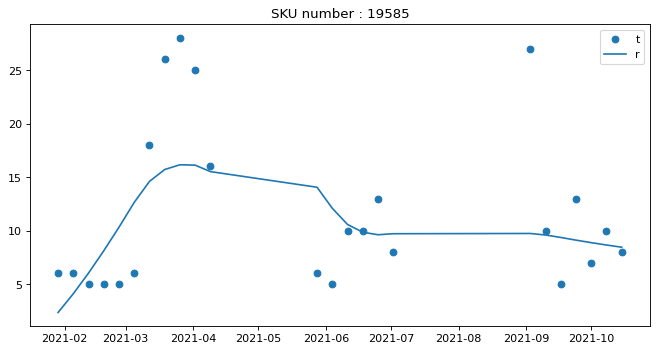

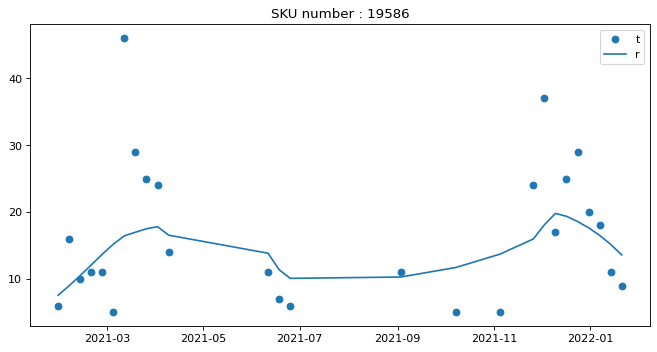

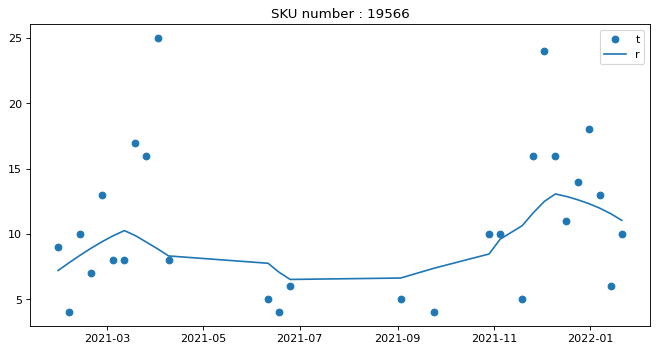

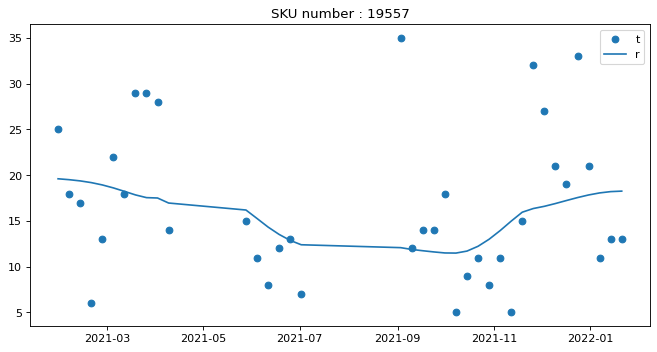

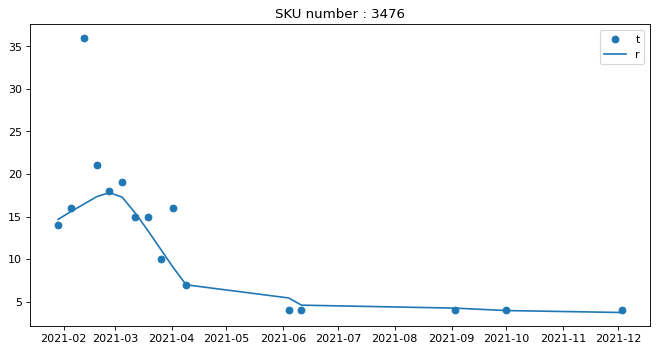

In [123]:
# Checking few SKUs
sku_list=['19585', '19586', '19566','19557',  '3476']

for sku in sku_list:
    plt.figure(figsize=(10, 5), dpi=80)

    sku_data = df_feat.loc[(df_feat['banner']=='CDS') & (df_feat['sku_id_upd']==sku)]

    plt.title("SKU number : "+sku)
    plt.scatter(sku_data.ds,sku_data.units)
    plt.plot(sku_data.ds, sku_data['trend_' + str(config.lowess_trend_n)])
    plt.gca().legend(('trend_' + str(config.lowess_trend_n)))
    plt.show()


### 8.3 One-Hot Encoding of categorical data

In [124]:
df_feat_ohe = df_feat.copy()
print(f"Before filtering: {df_feat_ohe.shape}")
df_feat_ohe = df_feat_ohe[df_feat_ohe['units']>0]
print(f"After filtering: {df_feat_ohe.shape}")

Before filtering: (63585, 39)
After filtering: (63585, 39)


In [125]:
df_feat_ohe = pd.get_dummies(df_feat_ohe, columns=["DISCOUNT_RULE"])

In [126]:
df_feat_ohe.shape

(63585, 42)

In [127]:
df_feat_ohe.head()

,banner,sku_id_upd,ds,GROSS_SALES_INC_VAT,NET_SALES_AMT_INC_VAT,units,COST_OF_GOODS_SOLD,PERMANENT_MARKDOWN_INC_VAT,Disc,total_disc,NET_MARGIN_AMT_EXC_VAT,base_price,price,mode_base_price,promo_yn,discount,ds_end,middle_date,month,year,weeknum,week,has_New_Year,has_songkran,has_queen_mother_bday,has_other_holidays,has_christmas_holiday,has_sep9_holiday,has_oct10_holiday,has_nov11_holiday,has_Chinese_New_Year,has_songkran_prior1week,has_songkran_prior2weeks,has_songkran_prior3weeks,has_christmas_prior1week,has_christmas_prior2weeks,has_christmas_prior3weeks,trend_2,DISCOUNT_RULE_Line Discount,DISCOUNT_RULE_Mix&Match Amount,DISCOUNT_RULE_Mix&Match Quantity,DISCOUNT_RULE_Total Or Ontop Discount
0,CDS,100,2021-09-03,7950.0,6360.00,6,1735.0,0.0,1590.00,1590.00,4208.95,1590.0,1060.000000,1590.0,1,0.333333,2021-09-03,2021-09-03,9,2021,35,202135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.470811,1,0,0,0
1,CDS,100,2021-09-10,7950.0,5801.00,5,1735.0,0.0,2149.00,2149.00,3686.51,1590.0,1160.200000,1590.0,1,0.270314,2021-09-10,2021-09-10,9,2021,36,202136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.396435,1,0,0,0
2,CDS,100,2021-10-01,7950.0,6060.00,5,1735.0,0.0,1890.00,1890.00,3928.57,1590.0,1212.000000,1590.0,1,0.237736,2021-10-01,2021-10-01,10,2021,39,202139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.347788,1,0,0,0
3,CDS,100,2021-10-08,7950.0,5401.45,5,1735.0,0.0,2548.55,2548.55,3313.10,1590.0,1080.290000,1590.0,1,0.320572,2021-10-08,2021-10-08,10,2021,40,202140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.333702,1,0,0,0
4,CDS,100,2021-10-15,9540.0,7529.47,6,2082.0,0.0,2010.53,2010.53,4954.91,1590.0,1254.911667,1590.0,1,0.210747,2021-10-15,2021-10-15,10,2021,41,202141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.452185,1,0,0,0


### 8.4 Correlations between discount% and units

In [128]:
corr_df_check = df_feat_ohe.groupby(['banner','sku_id_upd'])[['units','discount']].corr().iloc[0::2][['discount']].reset_index()

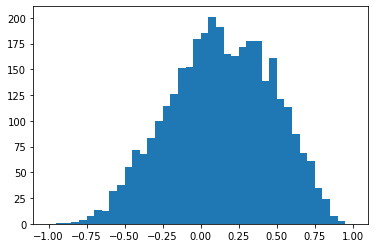

In [129]:
plt.hist(corr_df_check['discount'], bins=[i*0.05 for i in range(-20,21)]);

In [130]:
# Check number of SKUs that have negative correlation
corr_df_check.shape, corr_df_check[corr_df_check['discount']<0].shape

((3464, 4), (1211, 4))

# <span style="color:#c6aa3d">9. Preparing data for modeling</span><a class="anchor" id="9-bullet"></a>

### 9.1 Splitting data into Train & Test

In [131]:
df_feat_ohe['week_level'] = df_feat_ohe['banner'].astype(str)+'_'+df_feat_ohe['sku_id_upd'].astype(str)+'_'+df_feat_ohe['week'].astype(str)
df_feat_ohe['rfg'] = df_feat_ohe['banner'].astype(str)+'_'+df_feat_ohe['sku_id_upd'].astype(str)

In [132]:
df_feat_ohe = df_feat_ohe.sort_values(['rfg', 'ds'])

df_test = df_feat_ohe.groupby('rfg',as_index=False).tail(config.test_data_length)
df_train = df_feat_ohe[~df_feat_ohe.week_level.isin(list(df_test.week_level.unique()))]

In [133]:
df_test.shape

(13853, 44)

In [134]:
# Refining test data to include only those rfgs that are also in train set
df_test = df_test[df_test.rfg.isin(df_train.rfg.unique())]

In [135]:
df_test.shape

(13852, 44)

### 9.2 Selecting relevant fields

In [136]:
feature_selection = ['banner', 'sku_id_upd', 'rfg', 'ds','units',
                     
                     'base_price','price','discount','NET_SALES_AMT_INC_VAT', 'GROSS_SALES_INC_VAT',
                     
                     'promo_yn',
                     
                     'trend_' + str(config.lowess_trend_n),
                     
                     'has_New_Year', 'has_songkran', 'has_songkran_prior1week', 'has_songkran_prior2weeks', 'has_songkran_prior3weeks',
                     'has_queen_mother_bday', 'has_other_holidays',
                     'has_christmas_holiday', 'has_christmas_prior1week', 'has_christmas_prior2weeks','has_christmas_prior3weeks', 
                     'has_sep9_holiday', 'has_oct10_holiday', 'has_nov11_holiday', 'has_Chinese_New_Year',

                     'DISCOUNT_RULE_Line Discount', 'DISCOUNT_RULE_Mix&Match Amount', 'DISCOUNT_RULE_Mix&Match Quantity', 'DISCOUNT_RULE_Total Or Ontop Discount',
                    ]        

In [137]:
df_train = df_train[feature_selection]
df_test = df_test[feature_selection]

In [138]:
print(f'size of train data {df_train.shape}')
print(f'size of test data {df_test.shape}')

size of train data (49732, 31)
size of test data (13852, 31)


In [139]:
df_train_and_test = pd.concat([df_train, df_test], axis=0)

### 9.3 Preparing list of SKUs with significant difference between train and test

**Objective**: SKUs with significant difference in avg. units between test and train period are expected to show high model errors and possibly also unrealistic baselines. Hence, we flag such SKUs and remove them later from the analysis

In [140]:
train_avg_units_df = df_train.groupby(['rfg']).agg({'units':'mean'}).reset_index()
test_avg_units_df = df_test.groupby(['rfg']).agg({'units':'mean'}).reset_index()
train_test_avg_units_df = pd.merge(train_avg_units_df, test_avg_units_df, how="inner", on="rfg")
train_test_avg_units_df['drop_in_sales_test'] = 1-(train_test_avg_units_df['units_y']/train_test_avg_units_df['units_x'])

In [141]:
sku_type_df2 = train_test_avg_units_df.copy()
sku_type_df2['sku_type'] = np.where(sku_type_df2['drop_in_sales_test'].abs() > config.sudden_test_units_change_threshold,
                                    "Sudden vol change in test period","Regular SKU")

sku_type_df2.drop(['units_x','units_y','drop_in_sales_test'], axis=1, inplace = True)

In [142]:
sku_type_df2['sku_type'].value_counts(dropna=False)

Regular SKU                         3357
Sudden vol change in test period     106
Name: sku_type, dtype: int64

# <span style="color:#c6aa3d">10. Modeling</span><a class="anchor" id="10-bullet"></a>

### 10.1 Final features for modeling

In [143]:
target = "units"

In [144]:
first_step_variables = [
                        'trend_' + str(config.lowess_trend_n),
                        
                        'discount',
                        
                        'has_New_Year', 'has_Chinese_New_Year', 'has_songkran', 
                        'has_songkran_prior1week', 'has_songkran_prior2weeks', 'has_songkran_prior3weeks',                    
                        'has_sep9_holiday', 'has_oct10_holiday', 'has_nov11_holiday',
                        'has_christmas_holiday', 
                        'has_christmas_prior1week', 'has_christmas_prior2weeks', 'has_christmas_prior3weeks'
                       ]


second_step_variables = [
                    'DISCOUNT_RULE_Line Discount', 'DISCOUNT_RULE_Mix&Match Amount', 
                    'DISCOUNT_RULE_Mix&Match Quantity'
                        ]
                        

In [145]:
print(f"first step vars: {first_step_variables}\n")
print(f"second step vars: {second_step_variables}")

first step vars: ['trend_2', 'discount', 'has_New_Year', 'has_Chinese_New_Year', 'has_songkran', 'has_songkran_prior1week', 'has_songkran_prior2weeks', 'has_songkran_prior3weeks', 'has_sep9_holiday', 'has_oct10_holiday', 'has_nov11_holiday', 'has_christmas_holiday', 'has_christmas_prior1week', 'has_christmas_prior2weeks', 'has_christmas_prior3weeks']

second step vars: ['DISCOUNT_RULE_Line Discount', 'DISCOUNT_RULE_Mix&Match Amount', 'DISCOUNT_RULE_Mix&Match Quantity']


### 10.2 Running the 2-step model

**Objective**: Here we run the model in 2-steps:
- The first step takes the first step features and fits a regression model using log of units as target (if `log` transformation is chosen in `run_pool.py` function). The residuals are calculated as the ratio of actual and predicted units (for `multiplicative` option)
- The second step then uses the second step features and fits a regression model but this time using log of residual as the target. The final model is the chained prediction of these individual models

**Note**: This model is run separately for each SKU. To speed up, we parallelize the process using multiple cores of the CPU

In [146]:
# Running model for each SKU and creation of baseline and predicted units
with Pool(cpu_count() - 2) as p:
    models_list_all = list(tqdm.tqdm(p.imap(generate_2_steps_models,
                                            [(sku_df, df_train, df_test, first_step_variables, second_step_variables, 
                                              target, model_output_path, True)
                                             for name, sku_df in df_train.groupby('rfg')], 
                                            int(df_train['rfg'].nunique()/(cpu_count() - 2))),
                                     total=df_train['rfg'].nunique()))

100%|██████████████████████████████████████████████████████████████████████████████| 3463/3463 [00:57<00:00, 59.82it/s]


In [147]:
# Saving model results into separate objects
models_dict = {item[0]:item[1] for item in models_list_all }
base_df_fin = pd.concat([item[2] for item in models_list_all])
param_df =    pd.concat([item[3] for item in models_list_all])
pred_df =     pd.concat([item[4] for item in models_list_all])
wmape_df =    pd.concat([item[5] for item in models_list_all])

# <span style="color:#c6aa3d">11. Analyzing model results</span><a class="anchor" id="11-bullet"></a>

### 11.1 Plotting SKUs

In [148]:
# Joining prediction, baseline & original DF together
pred_and_baseline_plot_df = pred_df.copy()
pred_and_baseline_plot_df = pd.merge(pred_and_baseline_plot_df, 
                             base_df_fin[["rfg", "ds", "yhat"]], 
                             how="inner", 
                             on=["rfg", "ds"])
pred_and_baseline_plot_df = pred_and_baseline_plot_df.rename(columns={"yhat_x": "yhat",
                                                      "yhat_y": "yhat_baseline"
                                                     })

pred_and_baseline_plot_df = pd.merge(pred_and_baseline_plot_df, 
                             df_train_and_test[["rfg", "ds", "price", "base_price"]],
                             how="inner",
                             on=["rfg", "ds"])

assert pred_df.shape[0]==pred_and_baseline_plot_df.shape[0], "[ERROR] Rows are being dropped"

In [149]:
wmape_param_plot_df = wmape_df.copy()

wmape_param_plot_df = pd.merge(wmape_param_plot_df,
                              param_df.add_prefix('coeff_'),
                              how='inner',
                              left_on='rfg', right_on='coeff_rfg')


#### 11.1.1 Plotting good elasticity SKUs

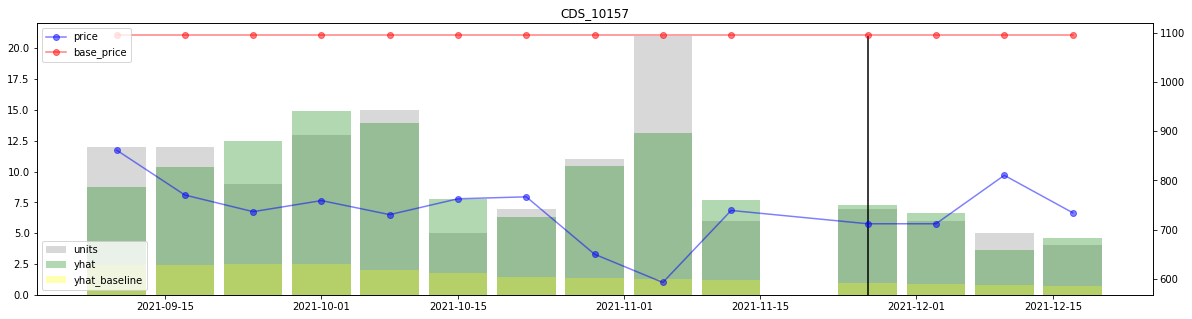

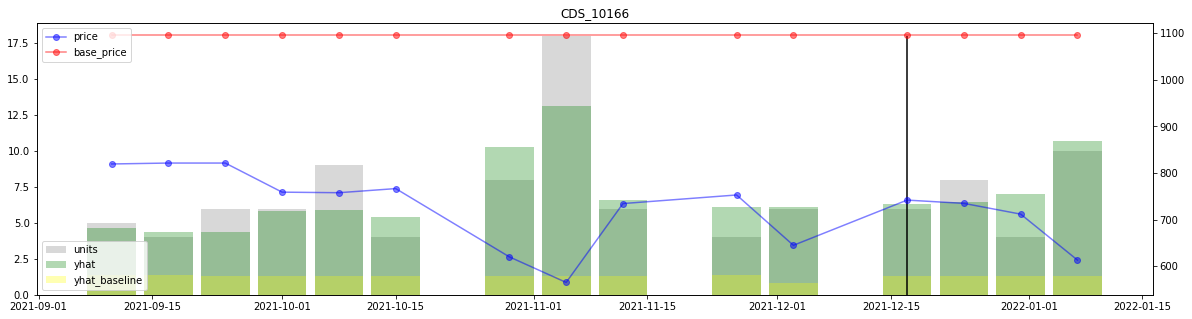

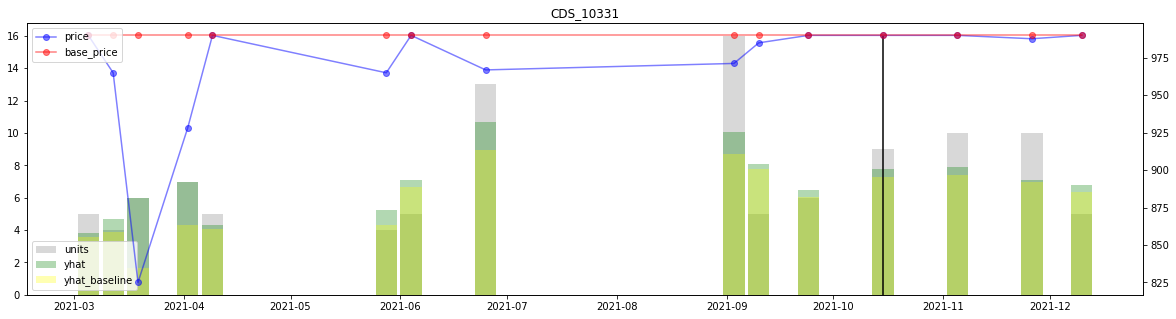

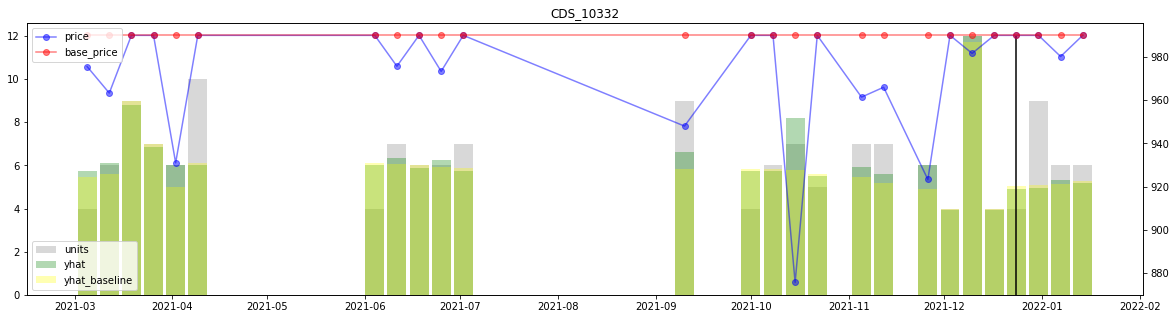

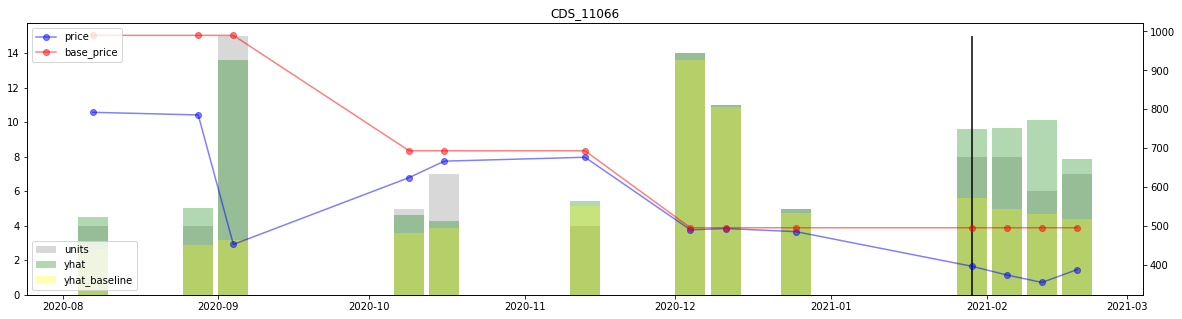

In [150]:
for item in wmape_param_plot_df.query('test_wmape<0.3 and coeff_discount>2.5').head(5).rfg.unique():
    split_date = pred_and_baseline_plot_df[pred_and_baseline_plot_df.rfg==item]['ds'].tail(config.test_data_length).min().strftime("%Y%m%d")
    plot_ts(pred_and_baseline_plot_df[pred_and_baseline_plot_df.rfg==item], left_axis=['units', 'yhat', 'yhat_baseline'], 
            right_axis=['price', 'base_price'], plot_dateline=split_date)

#### 11.1.2 Plotting negative elasticity SKUs

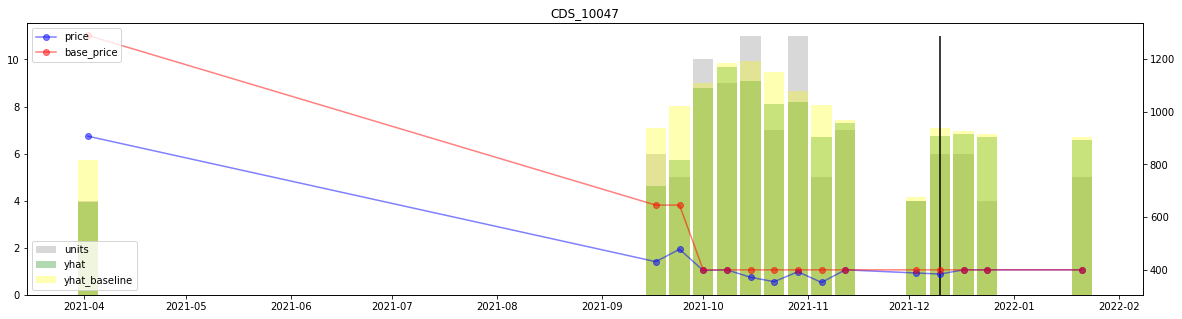

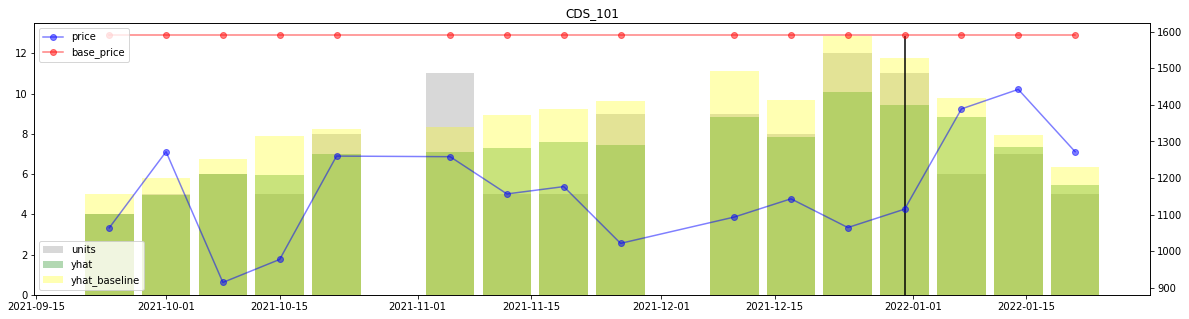

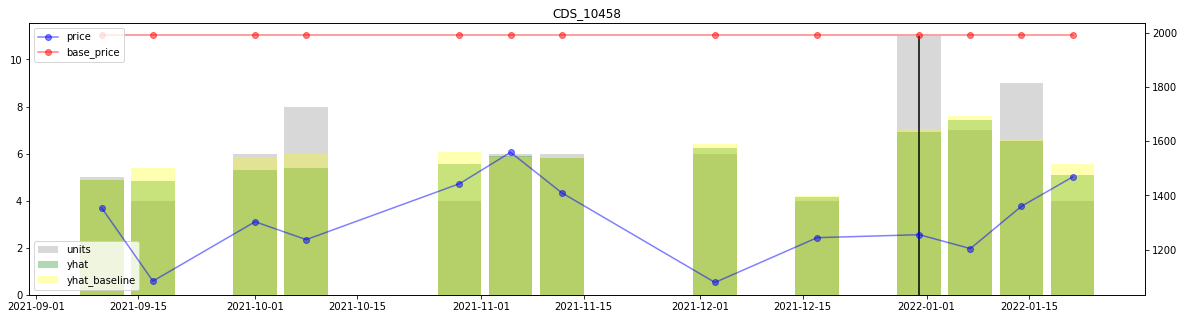

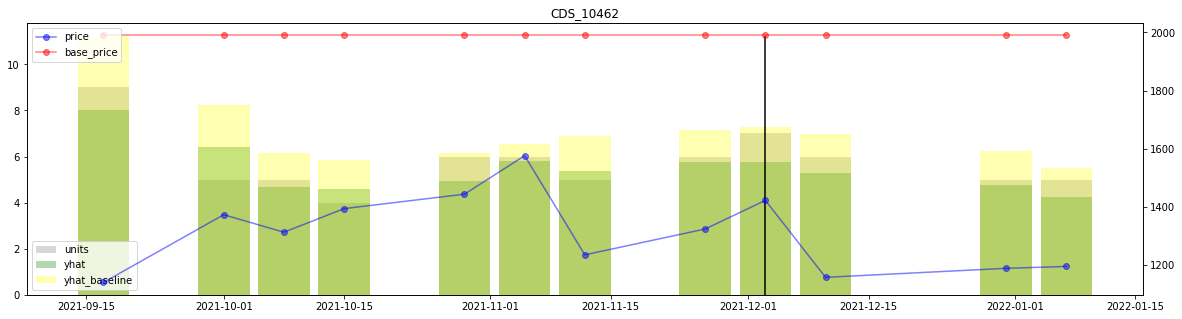

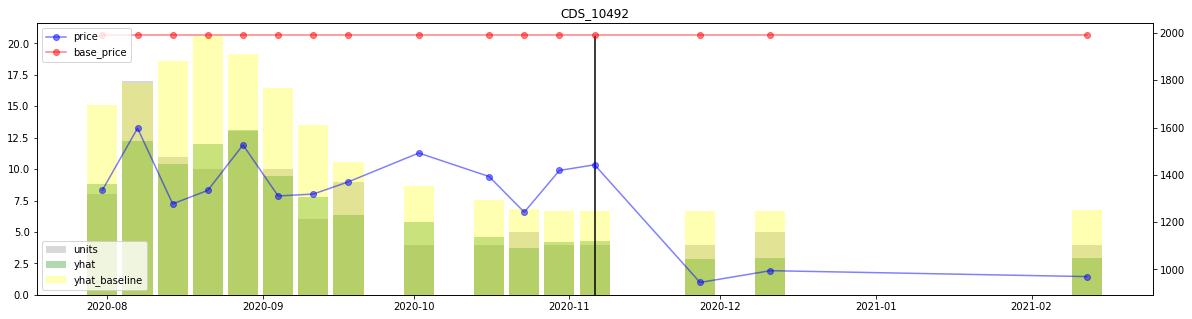

In [151]:
for item in wmape_param_plot_df.query('test_wmape<0.3 and coeff_discount<0').head(5).rfg.unique():
    split_date = pred_and_baseline_plot_df[pred_and_baseline_plot_df.rfg==item]['ds'].tail(config.test_data_length).min().strftime("%Y%m%d")
    plot_ts(pred_and_baseline_plot_df[pred_and_baseline_plot_df.rfg==item], left_axis=['units', 'yhat', 'yhat_baseline'], 
            right_axis=['price', 'base_price'], plot_dateline=split_date)

### 11.2  Analyzing test wmape

In [152]:
wmape_df['test_wmape'].describe().apply('{0:.2f}'.format)

count               3463.00
mean         82849823227.15
std        4875483303554.23
min                    0.01
25%                    0.19
50%                    0.28
75%                    0.40
max      286908833226285.31
Name: test_wmape, dtype: object

In [153]:
# Analysing the same plot after removing very high wmape values
wmape_df[wmape_df['test_wmape'] <= config.test_wmape_filter_threshold]['test_wmape'].describe().apply('{0:.2f}'.format)

count    3448.00
mean        0.37
std         0.47
min         0.01
25%         0.19
50%         0.28
75%         0.40
max         8.27
Name: test_wmape, dtype: object

In [154]:
wmap_df_wo_high_val = wmape_df[wmape_df['test_wmape'] <= config.test_wmape_filter_threshold]

### 11.3 Analyzing sudden test units change SKUs

In [155]:
sudden_vol_drop_df = sku_type_df2.copy()
sudden_vol_drop_df = wmap_df_wo_high_val.merge(sudden_vol_drop_df,
                                               on='rfg',
                                               how='left')

sudden_vol_drop_df.groupby('sku_type').agg({'test_wmape':['mean', 'count']}).reset_index()

sku_type test_wmape      
                                          mean count
0                       Regular SKU   0.359022  3343
1  Sudden vol change in test period   0.815295   105

### 11.4 Analyzing elasticity

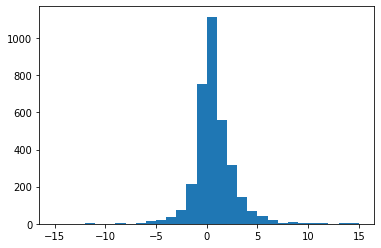

In [156]:
plt.hist(param_df['discount'], bins=[i for i in range(-15,16)]);

In [157]:
# Checking proportion of negative elasticity SKUs
param_df[param_df['discount']<0].shape[0]/param_df.shape[0]

0.3306381749927808

# <span style="color:#c6aa3d">12. Filtering results</span><a class="anchor" id="12-bullet"></a>

**Objective**: Following SKUs are removed:
- ***SKUs with very high test wmape***: Caused due to some specific SKUs- can be looked into further but ignoring due to very few such SKUs
- ***SKUs with negative or very high elasticity***: Negative elasticity is counter-intuitive and could be due to stock-outs and would require inventory data going back 2-3 years to investigate (however currently we don't have such historical inventory data). Also removing few very high wmape SKUs
- ***SKUs with avg. test period units very different from avg. train period units***: Few SKUs have test period avg. units very different than train period avg. units, leading to high wmape
- ***SKUs that have very high baseline vs. actual units***: Remove such few SKUs as they skew the total baseline

### 12.1 Preparing exclusion SKU list

In [158]:
high_test_wmape_SKU = wmape_df[wmape_df['test_wmape']>config.test_wmape_filter_threshold]['rfg']
high_elasticity_SKU = param_df[param_df['discount']>config.elasticity_filter_threshold]['rfg']
negative_elasticity_SKU = param_df[param_df['discount']<0]['rfg']
sudden_vol_change_SKUs = sku_type_df2[sku_type_df2['sku_type']=="Sudden vol change in test period"]['rfg']

# Excluding SKU with very high baseline values
base_fin_exclusion = base_df_fin.copy()
base_fin_exclusion['baseline_actual_diff'] = (base_fin_exclusion['yhat']/base_fin_exclusion['units']) - 1
base_fin_exclusion = base_fin_exclusion[base_fin_exclusion['baseline_actual_diff'] > config.base_units_diff_multiplier_threshold]
base_fin_exclusion = base_fin_exclusion['rfg']

SKU_exclusion_list = pd.concat([high_test_wmape_SKU, high_elasticity_SKU,
                                negative_elasticity_SKU, 
                                sudden_vol_change_SKUs,
                               base_fin_exclusion
                               ])

SKU_exclusion_list = SKU_exclusion_list.drop_duplicates()

print(f"SKU/banner combinations to be excluded:{SKU_exclusion_list.shape[0]}")

SKU/banner combinations to be excluded:1245


### 12.2 Filtering results

In [159]:
base_df_final =  base_df_fin[~(base_df_fin['rfg'].isin(SKU_exclusion_list))]
param_df_final = param_df[~(param_df['rfg'].isin(SKU_exclusion_list))]
pred_df_final =  pred_df[~(pred_df['rfg'].isin(SKU_exclusion_list))]
wmape_df_final = wmape_df[~(wmape_df['rfg'].isin(SKU_exclusion_list))]

# <span style="color:#c6aa3d">13. Calculating elasticities and exporting results</span><a class="anchor" id="13-bullet"></a>

### 13.1 Mapping brand, subclass, Credit/Consignment flag and net sales

In [160]:
df_elasticity = param_df_final.copy().add_prefix('coeff_').rename(columns={'coeff_rfg':'rfg'})
df_elasticity = df_elasticity.merge(wmape_df_final, on='rfg', how='inner')

df_elasticity['banner'] = df_elasticity['rfg'].str.split('_').str[0]
df_elasticity['sku_id_upd'] = df_elasticity['rfg'].str.split('_').str[1]

# Mapping brand and subclass
df_elasticity = df_elasticity.merge(df_sku_new, on='sku_id_upd', how='left')

# Mapping credit/consignment flag
df_elasticity = df_elasticity.merge(model_df[['sku_id_upd','CREDIT_CONSIGN']].drop_duplicates(), on='sku_id_upd', how='left')

# Mapping net sales
sku_net_sales_df = df_train_and_test.groupby('rfg')['NET_SALES_AMT_INC_VAT'].sum().reset_index()
df_elasticity = df_elasticity.merge(sku_net_sales_df, on='rfg', how='inner')

### 13.2 Calculating avg. weighted elasticity for brand and subclass

In [161]:
# Elasticity at banner-brand level
df_elasticity_brand = custom_funcs.roll_up_elasticities(df_elasticity,
                                                        group_vars = ['banner','BRAND_GROUP','CREDIT_CONSIGN'],
                                                       wmape = 'test_wmape',
                                                        values = 'coeff_discount',
                                                       weights = 'NET_SALES_AMT_INC_VAT')

In [162]:
# Elasticity at banner-brand-subclass level
df_elasticity_subclass = custom_funcs.roll_up_elasticities(df_elasticity,
                                                        group_vars = ['banner','BRAND_GROUP','CREDIT_CONSIGN','SUBCLASS'],
                                                       wmape = 'test_wmape',
                                                        values = 'coeff_discount',
                                                       weights = 'NET_SALES_AMT_INC_VAT')

### 13.3 Exporting results

In [163]:
# Exporting elasticities
df_elasticity_brand.to_csv(notebook_output_path + 'elasticity_by_brand_banner.csv', index=False)
df_elasticity_subclass.to_csv(notebook_output_path + 'elasticity_by_brand_subclass_banner.csv', index=False)

# Exporting baseline
base_df_final.to_csv(notebook_output_path + 'sku_baseline.csv', index=False)

# <span style="color:#c6aa3d">14. Exporting interim files for later analysis</span><a class="anchor" id="14-bullet"></a>

### 14.1 Exporting model results

In [164]:
param_df_final.to_pickle(baseline_interim_out_path + "param_df_final.pkl")
pred_df_final.to_pickle(baseline_interim_out_path + "pred_df_final.pkl")
base_df_final.to_pickle(baseline_interim_out_path + "base_df_final.pkl")

### 14.2 Exporting features data

In [165]:
df_feat_ohe.to_pickle(baseline_interim_out_path + "features_df.pkl")

### 14.3 Exporting SKU attributes mapping

In [166]:
df_sku_new_mapping = df_sku_new.copy()
df_sku_new_mapping = df_sku_new_mapping.merge(sales_filter[['sku_id_upd','CREDIT_CONSIGN']].drop_duplicates(),
                                             on='sku_id_upd', how='left')

# Check that no many to many mapping
assert df_sku_new_mapping.shape[0]==df_sku_new.shape[0]

df_sku_new_mapping.to_pickle(baseline_interim_out_path + "sku_new_mapping.pkl")

### 14.4 Exporting aggregated raw modeling data (selected metrics)

In [167]:
model_df_grouped = model_df.groupby(group).agg({'PROMOTION_REBATE_AMT': 'sum',
                                                'SPECIAL_GP_AMT': 'sum',
                                                'DISCOUNT_SHARING_AMT': 'sum',
                                                'GROSS_SALES_EXC_VAT':'sum',
                                                'NET_SALES_AMT_EXC_VAT':'sum'}).reset_index()

model_df_grouped.to_pickle(baseline_interim_out_path + "model_df_grouped.pkl")

### 14.5 Exporting aggregated full raw data (selected metrics)

In [168]:
full_df_grouped = sales_filter.groupby(group).agg({'NET_SALES_AMT_INC_VAT':'sum',
                                                   'NET_SALES_AMT_EXC_VAT':'sum',
                                                   'COST_OF_GOODS_SOLD':'sum'}).reset_index()

full_df_grouped.to_pickle(baseline_interim_out_path + "full_df_grouped.pkl")